In [19]:
import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score,confusion_matrix,roc_curve
from perpetual import PerpetualBooster
from tabpfn import TabPFNClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import StratifiedKFold
from collections import Counter

In [20]:
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

def load_feature(path,idx,val,zscore=True,batch=True):
    f=HNSCCFeatureHandler(METADATA_PATH,VALID_IDS_PATH,HOLD_IDS_PATH)
    f.load_feature_to_dataframe(path,idx,val)
    f.normalize_zscore()
    f.merge_feature_metadata()
    if batch: f.batch_correct()
    return f
    
metrics = []
delfi=load_feature("/projects/b1198/epifluidlab/ravi/0401/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed",1,12)
mds=load_feature("/projects/b1198/epifluidlab/ravi/0401/headneck/data/hg38_frag_filtered/*.hg38.frag.interval_mds.tsv",0,4)
train_ids=list(delfi.institute1_ids)+list(delfi.institute2_ids)+list(delfi.institute3_ids)+list(delfi.institute4_ids)
test_ids=list(delfi.institute5_ids)+list(delfi.institute6_ids)


def prepare_train_test(data):
    def build_df(ids):
        feats=data.get_raw_features(data.get_subset(ids))
        meta=data.get_metadata_col("Treatment Response",data.get_subset(ids))
        pno=data.get_metadata_col("Patient Number",data.get_subset(ids))
        tov=data.get_metadata_col("Type of Visit",data.get_subset(ids))
        return pd.concat([feats, meta, pno, tov],axis=1)
    return build_df(train_ids),build_df(test_ids),pd.concat([data.get_raw_features(data.hold_data),data.get_metadata_col("Patient Number",data.hold_data), data.get_metadata_col("Type of Visit",data.hold_data),data.get_metadata_col("Treatment Response",data.hold_data)],axis=1)

delfi_train,delfi_test,delfi_hold=prepare_train_test(delfi)
mds_train,mds_test,mds_hold=prepare_train_test(mds)

In [21]:
def compute_fold_metrics(y_true, y_prob, y_pred, fold=None):
    m = {
        "accuracy":      accuracy_score(y_true, y_pred),
        "f1":            f1_score(y_true, y_pred),
        "precision":     precision_score(y_true, y_pred),
        "recall":        recall_score(y_true, y_pred),
        "balanced_ac":   balanced_accuracy_score(y_true, y_pred),
        "roc_auc":       roc_auc_score(y_true, y_prob)
    }
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    m.update({
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    m["roc_curve"] = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    if fold is not None:
        m["fold"] = fold
    return m

def print_classification_metrics(df):
    y_true = df["Treatment Response"] == "Responder"
    y_pred = df["Predicted Treatment Response"] == "Responder"
    y_score = df["Final Weighted Prediction"]

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "balanced_ac": balanced_accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_score)
    }
    for k, v in metrics.items():
        print(f"{k}\t{v:.3f}")

def plot_metrics(metrics, title=''):
    fpr = metrics['roc_curve']['fpr']
    tpr = metrics['roc_curve']['tpr']
    roc_auc = metrics['roc_auc']
    cm = np.array([[metrics['tn'], metrics['fp']],
                   [metrics['fn'], metrics['tp']]])
    
    plt.figure(figsize=(8, 4), dpi=1000)
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='mediumpurple')
    plt.text(0.55, 0.05, f'ROC AUC: {roc_auc:.2f}', fontsize=12, color='red')
    plt.plot([0, 1], [0, 1], color='black', alpha=0.3, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(-0.03, 1)
    plt.ylim(0, 1.03)
    
    plt.subplot(1,2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Responder', 'Non-Responder'],
                yticklabels=['Responder', 'Non-Responder'])
    
    plt.tight_layout()
    plt.savefig(f'{title}.pdf')

def adjust_coefficients_mean(group):
    prob = group['mds'].mean()
    resp = group['Treatment Response'].iloc[0]
    return pd.Series({
        'Final Weighted Prediction': prob,
        'Treatment Response': resp,
        'Predicted Treatment Response': 'Responder' if prob >= 0.5 else 'Non-Responder'
    })

def adjust_coefficients_priority(group):
    visit_priority = {'Screen': 0, 'Day 0': 1, 'Adj Wk 1': 2}
    group = group.copy()
    group['Visit Priority'] = group['Type of Visit'].map(visit_priority)
    most_recent = group.loc[group['Visit Priority'].idxmax()]

    prob = most_recent['mds']
    resp = most_recent['Treatment Response']
    return pd.Series({
        'Final Weighted Prediction': prob,
        'Treatment Response': resp,
        'Predicted Treatment Response': 'Responder' if prob >= 0.5 else 'Non-Responder'
    })

def plot_roc(df, title, fname):
    fpr, tpr, _ = roc_curve(df['Treatment Response'] == 'Responder', df['Final Weighted Prediction'])
    auc_score = roc_auc_score(df['Treatment Response'] == 'Responder', df['Final Weighted Prediction'])
    plt.figure(figsize=(2, 2), dpi=300)
    plt.plot(fpr, tpr, color="mediumpurple")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.3)
    plt.text(0.4, 0.05, f"ROC AUC: {auc_score:.2f}", fontsize=6)
    plt.title(title, fontsize=6)
    plt.xlabel("False Positive Rate", fontsize=6)
    plt.ylabel("True Positive Rate", fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

def plot_cm(df, title, fname):
    cm = confusion_matrix(df['Treatment Response'], df['Predicted Treatment Response'], labels=['Responder', 'Non-Responder'])
    plt.figure(figsize=(2.5, 2.5), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Responder', 'Non-Responder'], yticklabels=['Responder', 'Non-Responder'],
                annot_kws={"fontsize": 6})
    plt.title(title, fontsize=6)
    plt.xlabel('Predicted Label', fontsize=6)
    plt.ylabel('True Label', fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

In [22]:
def train_model(
    df1, df2,
    response_col="Treatment Response",
    k_features1=500, k_features2=500,
    base_model_cls1=None, base_model_kwargs1=None,
    base_model_cls2=None, base_model_kwargs2=None,
    cv=10, random_state=42,
):
    X1 = df1.drop(columns=[response_col, "Patient Number", "Type of Visit"])
    X2 = df2.drop(columns=[response_col, "Patient Number", "Type of Visit"])
    y  = (df1[response_col] == "Responder").astype(int).to_numpy()

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    oof1 = np.zeros(len(df1))
    oof2 = np.zeros(len(df1))

    for i, (tr, val) in enumerate(skf.split(X1, y)):
        svd1 = TruncatedSVD(n_components=k_features1, random_state=random_state)
        svd2 = TruncatedSVD(n_components=k_features2, random_state=random_state)
        X1_tr, X1_val = svd1.fit_transform(X1.iloc[tr]), svd1.transform(X1.iloc[val])
        X2_tr, X2_val = svd2.fit_transform(X2.iloc[tr]), svd2.transform(X2.iloc[val])

        m1 = base_model_cls1(**(base_model_kwargs1 or {})).fit(X1_tr, y[tr])
        m2 = base_model_cls2(**(base_model_kwargs2 or {})).fit(X2_tr, y[tr])

        oof1[val] = m1.predict_proba(X1_val)[:, 1]
        oof2[val] = m2.predict_proba(X2_val)[:, 1]

        m1_prob = oof1[val]
        m1_pred = (m1_prob >= 0.5).astype(int)
        #metrics.append(compute_fold_metrics(y[val], m1_prob, m1_pred, fold=f"DELFI_{i}"))

        m2_prob = oof2[val]
        m2_pred = (m2_prob >= 0.5).astype(int)
        metrics.append(compute_fold_metrics(y[val], m2_prob, m2_pred, fold=f"MDS_{i}"))

    svd1 = TruncatedSVD(n_components=k_features1, random_state=random_state).fit(X1)
    svd2 = TruncatedSVD(n_components=k_features2, random_state=random_state).fit(X2)
    m1   = base_model_cls1(**(base_model_kwargs1 or {})).fit(svd1.transform(X1), y)
    m2   = base_model_cls2(**(base_model_kwargs2 or {})).fit(svd2.transform(X2), y)

    return svd1, svd2, m1, m2

def eval_model(
    df_test1, df_test2,
    svd1, svd2,
    m1, m2,
    name,
    response_col="Treatment Response"
):

    X1 = df_test1.drop(columns=[response_col, "Patient Number", "Type of Visit"])
    X2 = df_test2.drop(columns=[response_col, "Patient Number", "Type of Visit"])
    X1_red = svd1.transform(X1)
    X2_red = svd2.transform(X2)

    visits = ["Screen", "Day 0", "Adj Wk 1", "Overall"]
    probs = {"delfi": {}, "mds": {}, "ensemble": {}}

    for prefix, model, X_red in [("DELFI", m1, X1_red), ("MDS", m2, X2_red)]:
        df_test = df_test1 if prefix == "DELFI" else df_test2
        for visit in visits:
            mask = slice(None) if visit == "Overall" else (df_test["Type of Visit"] == visit)
            fold = "Overall" if visit == "Overall" else visit.replace(" ", "_")
            Xv = X_red[df_test.index.get_indexer(df_test.index[mask])]
            yv = (df_test.loc[mask, response_col] == "Responder").astype(int)
            p  = model.predict_proba(Xv)[:, 1]
            yp = (p >= 0.5).astype(int)
            if prefix!="DELFI":
                metrics.append(compute_fold_metrics(yv, p, yp, fold=f"{prefix}_{name}_{fold}"))
            probs[prefix.lower()][visit] = pd.Series(p, index=df_test.index[mask])


    p1     = pd.DataFrame(probs["delfi"]["Overall"], columns=["delfi"])
    p2     = pd.DataFrame(probs["mds"]["Overall"],   columns=["mds"])
    return p1, p2

delfi_svd, mds_svd, delfi_m, mds_m = train_model(
    delfi_train,mds_train,
    k_features1=10,
    k_features2=10,
    base_model_cls1=TabPFNClassifier,
    base_model_cls2=TabPFNClassifier,
    random_state=42
)

In [23]:
delfi_test_eval, mds_test_eval = eval_model(delfi_test, mds_test, delfi_svd, mds_svd, delfi_m, mds_m, "Institute_Hold_Out")
delfi_hold_eval, mds_hold_eval = eval_model(delfi_hold, mds_hold, delfi_svd, mds_svd, delfi_m, mds_m, "Pre_Hold_Out")

In [24]:
df_institute = pd.concat([delfi_test_eval, mds_test_eval, delfi_test['Treatment Response'], delfi_test['Patient Number'], delfi_test['Type of Visit']], axis=1)

In [25]:
institute_predictions = df_institute.groupby('Patient Number').apply(adjust_coefficients_mean)

In [26]:
institute_predictions

Final Weighted Prediction Treatment Response  \
Patient Number                                                 
18                               0.996756          Responder   
20                               0.559533      Non-Responder   
21                               0.928304          Responder   
22                               0.407323      Non-Responder   
23                               0.000809      Non-Responder   
24                               0.047512      Non-Responder   
25                               0.147459          Responder   
26                               0.430572      Non-Responder   
27                               0.002660      Non-Responder   
28                               0.868794      Non-Responder   
29                               0.990070          Responder   
30                               0.999880          Responder   
31                               0.976824          Responder   
32                               0.998991          Responder   
64                               0.981002          Responder   
65                               0.951129          Responder   

               Predicted Treatment Response  
Patient Number                               
18                                Responder  
20                                Responder  
21                                Responder  
22                            Non-Responder  
23                            Non-Responder  
24                            Non-Responder  
25                            Non-Responder  
26                            Non-Responder  
27                            Non-Responder  
28                                Responder  
29                                Responder  
30                                Responder  
31                                Responder  
32                                Responder  
64                                Responder  
65                                Responder

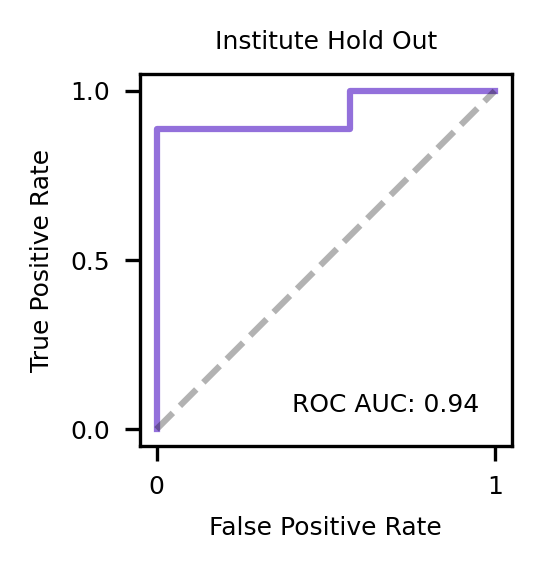

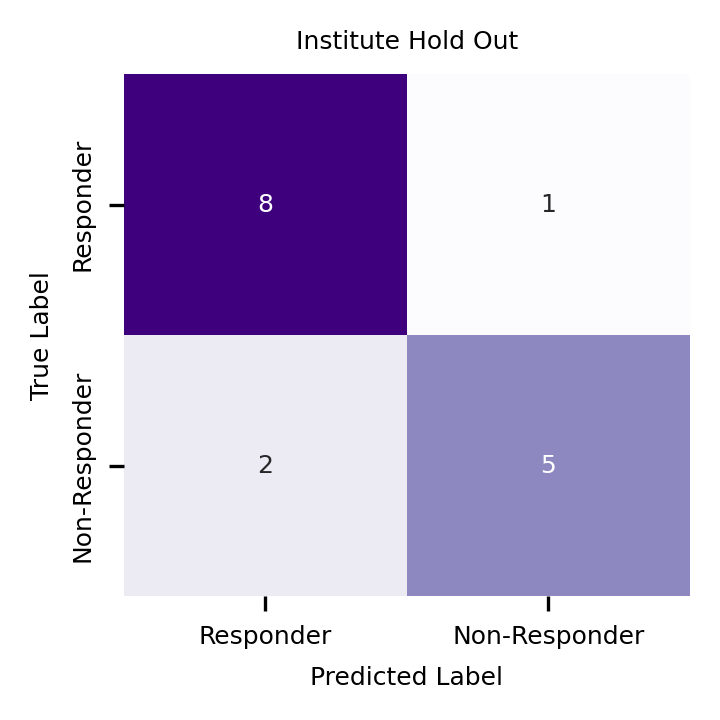

In [27]:
plot_roc(institute_predictions, "Institute Hold Out", "Institute_ROC.pdf")
plot_cm(institute_predictions, "Institute Hold Out", "Institute_CM.pdf")

In [28]:
print_classification_metrics(institute_predictions)

accuracy	0.812
f1	0.842
precision	0.800
recall	0.889
balanced_ac	0.802
roc_auc	0.937


In [29]:
df_hold = pd.concat([delfi_hold_eval, mds_hold_eval, delfi_hold['Treatment Response'], delfi_hold['Patient Number'], delfi_hold['Type of Visit']], axis=1)

In [30]:
hold_predictions = df_hold.groupby('Patient Number').apply(adjust_coefficients_mean)

In [31]:
hold_predictions

Final Weighted Prediction Treatment Response  \
Patient Number                                                 
12                               0.258095      Non-Responder   
15                               0.060383      Non-Responder   
16                               0.356922      Non-Responder   
19                               0.418601      Non-Responder   
37                               0.999218          Responder   
39                               0.999388          Responder   
43                               0.990552          Responder   
45                               0.339390          Responder   
52                               0.015075      Non-Responder   
66                               0.509058          Responder   

               Predicted Treatment Response  
Patient Number                               
12                            Non-Responder  
15                            Non-Responder  
16                            Non-Responder  
19                            Non-Responder  
37                                Responder  
39                                Responder  
43                                Responder  
45                            Non-Responder  
52                            Non-Responder  
66                                Responder

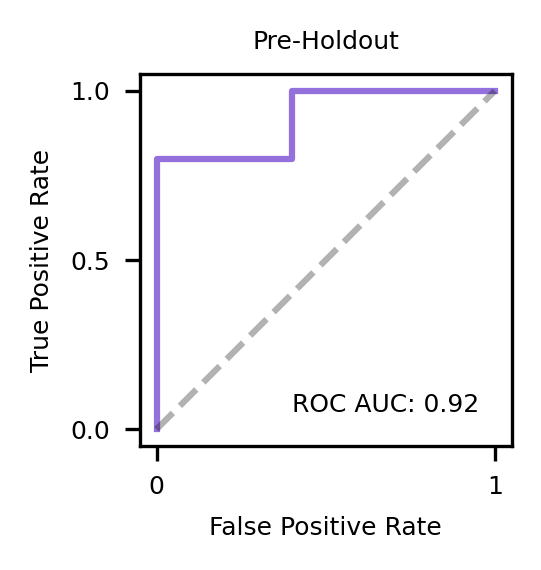

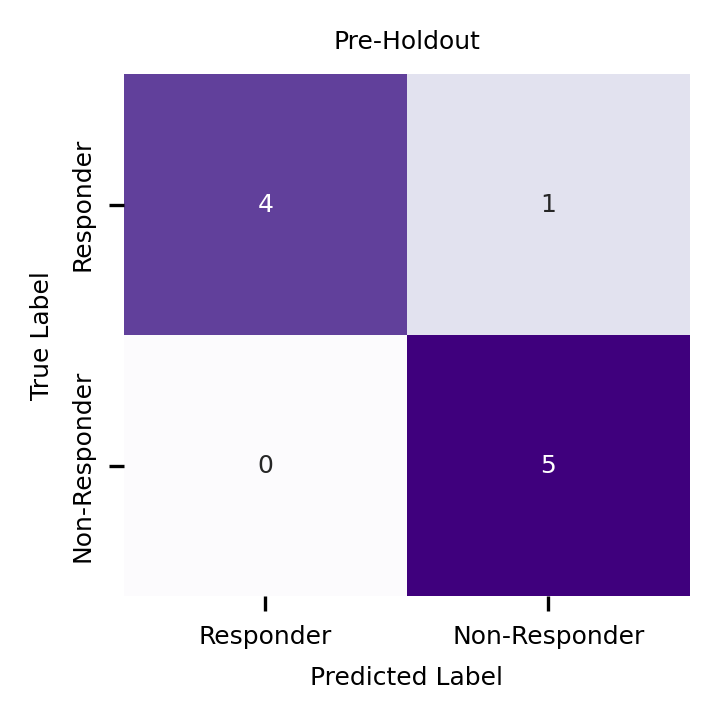

In [32]:
plot_roc(hold_predictions, "Pre-Holdout", "PreHold_ROC.pdf")
plot_cm(hold_predictions, "Pre-Holdout", "PreHold_CM.pdf")

In [33]:
print_classification_metrics(hold_predictions)

accuracy	0.900
f1	0.889
precision	1.000
recall	0.800
balanced_ac	0.900
roc_auc	0.920


In [34]:
pd.DataFrame(metrics).to_csv('ST5.csv')

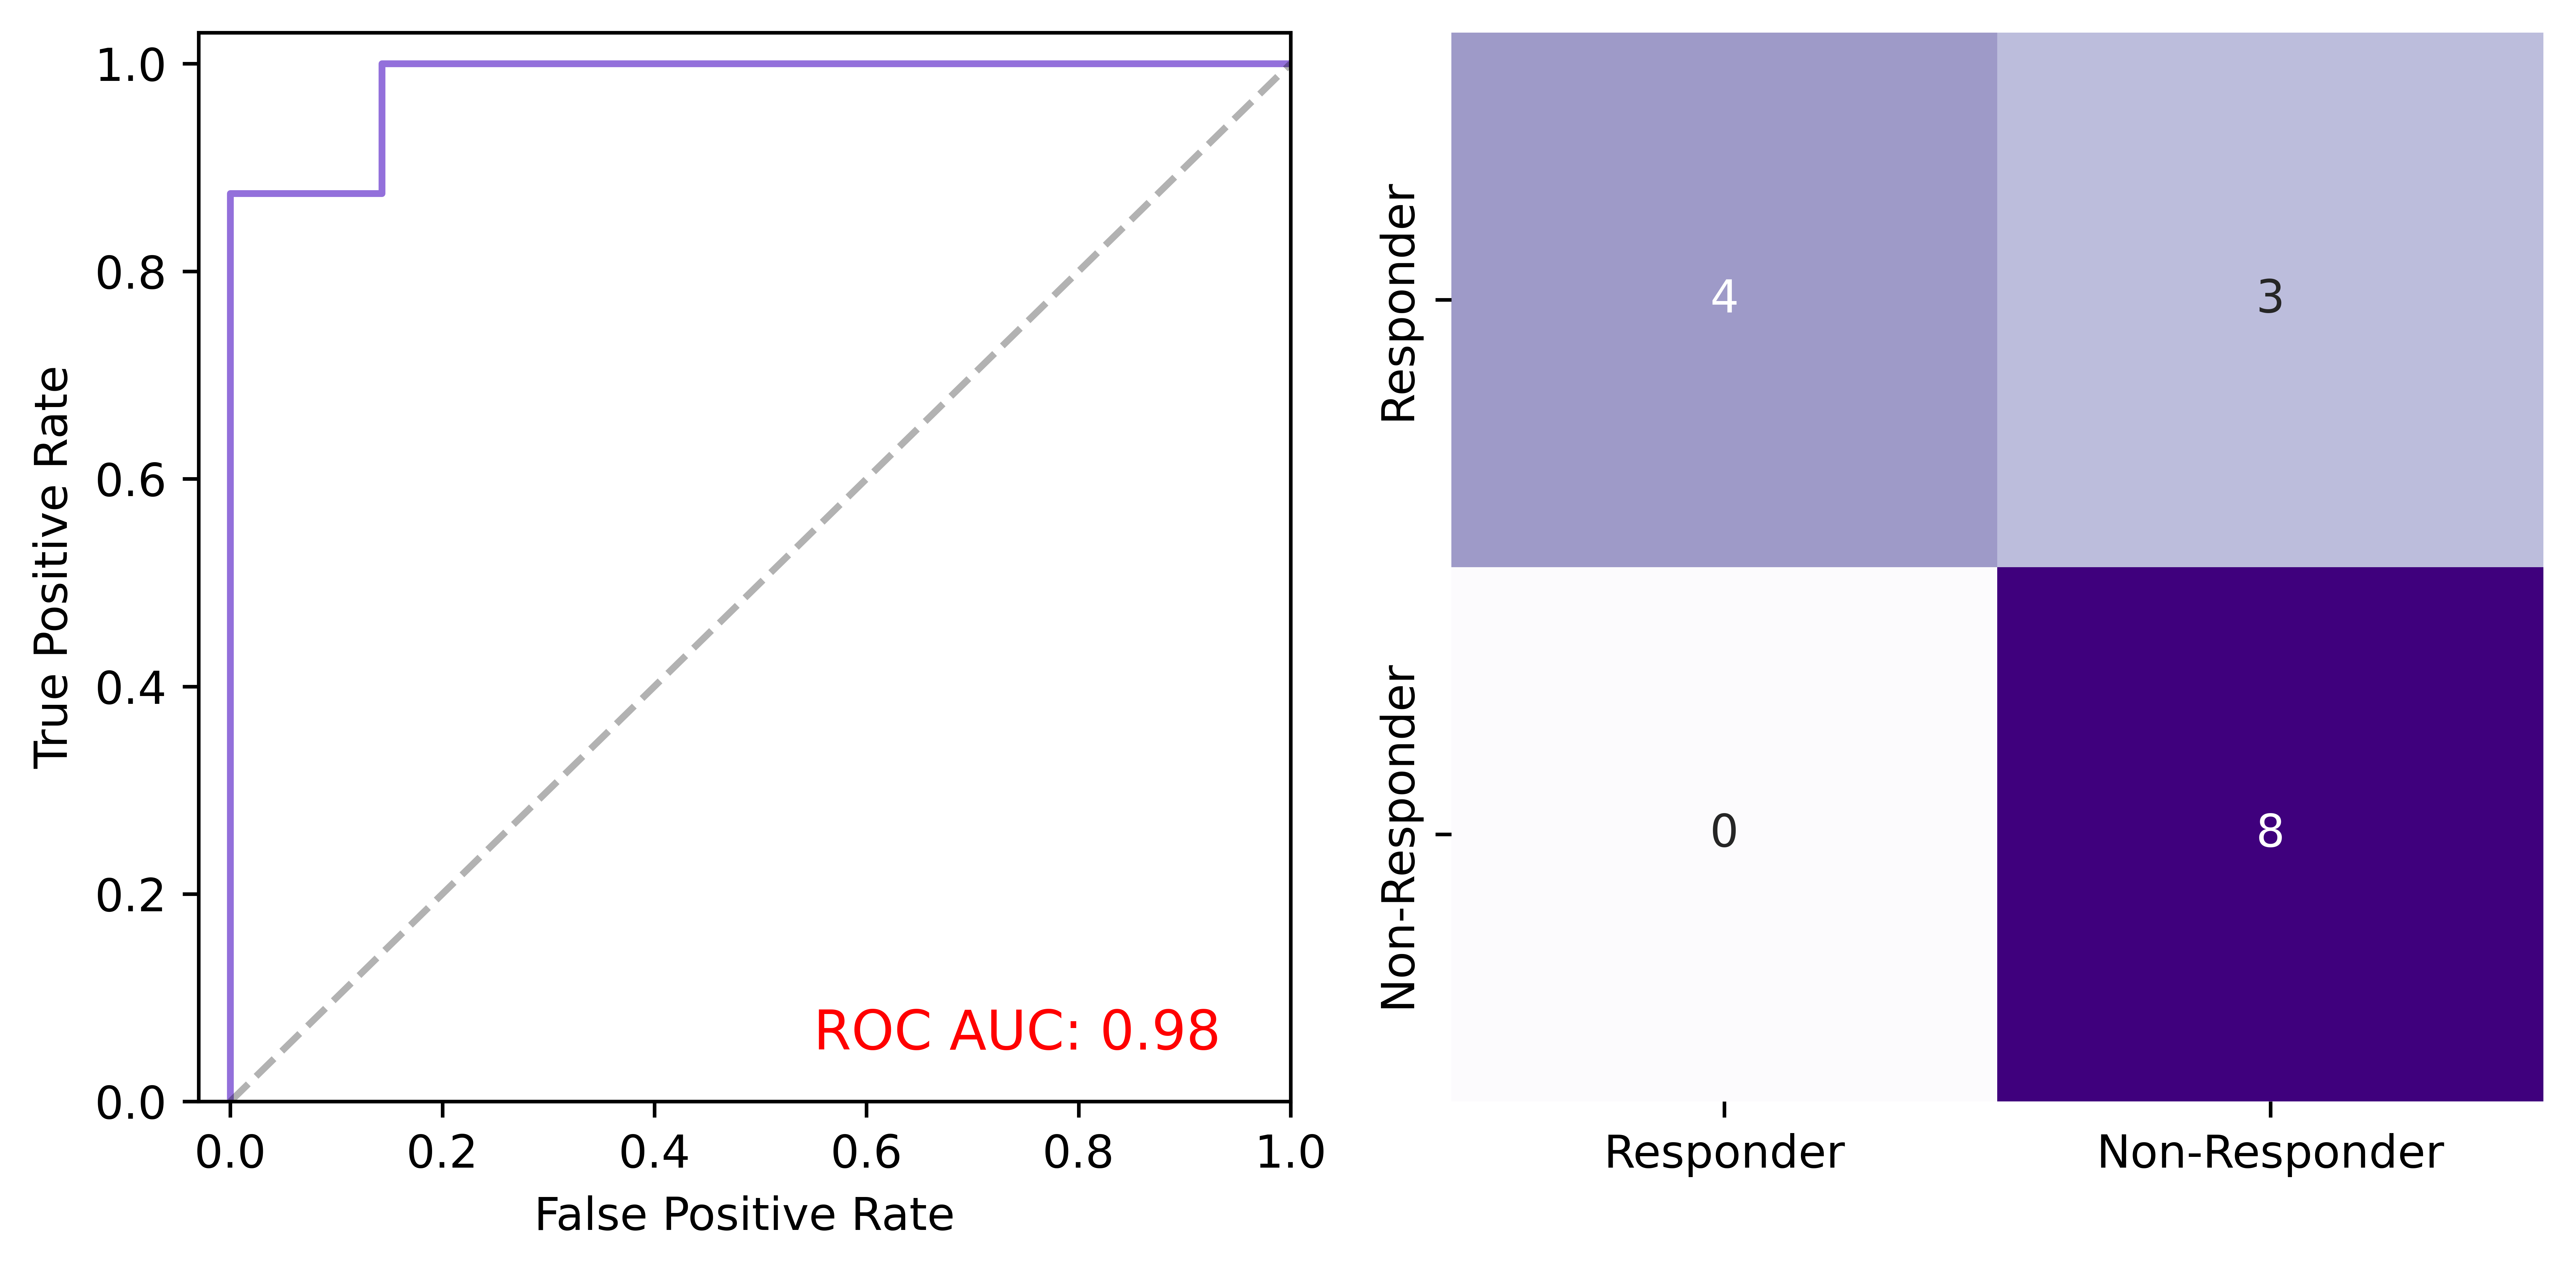

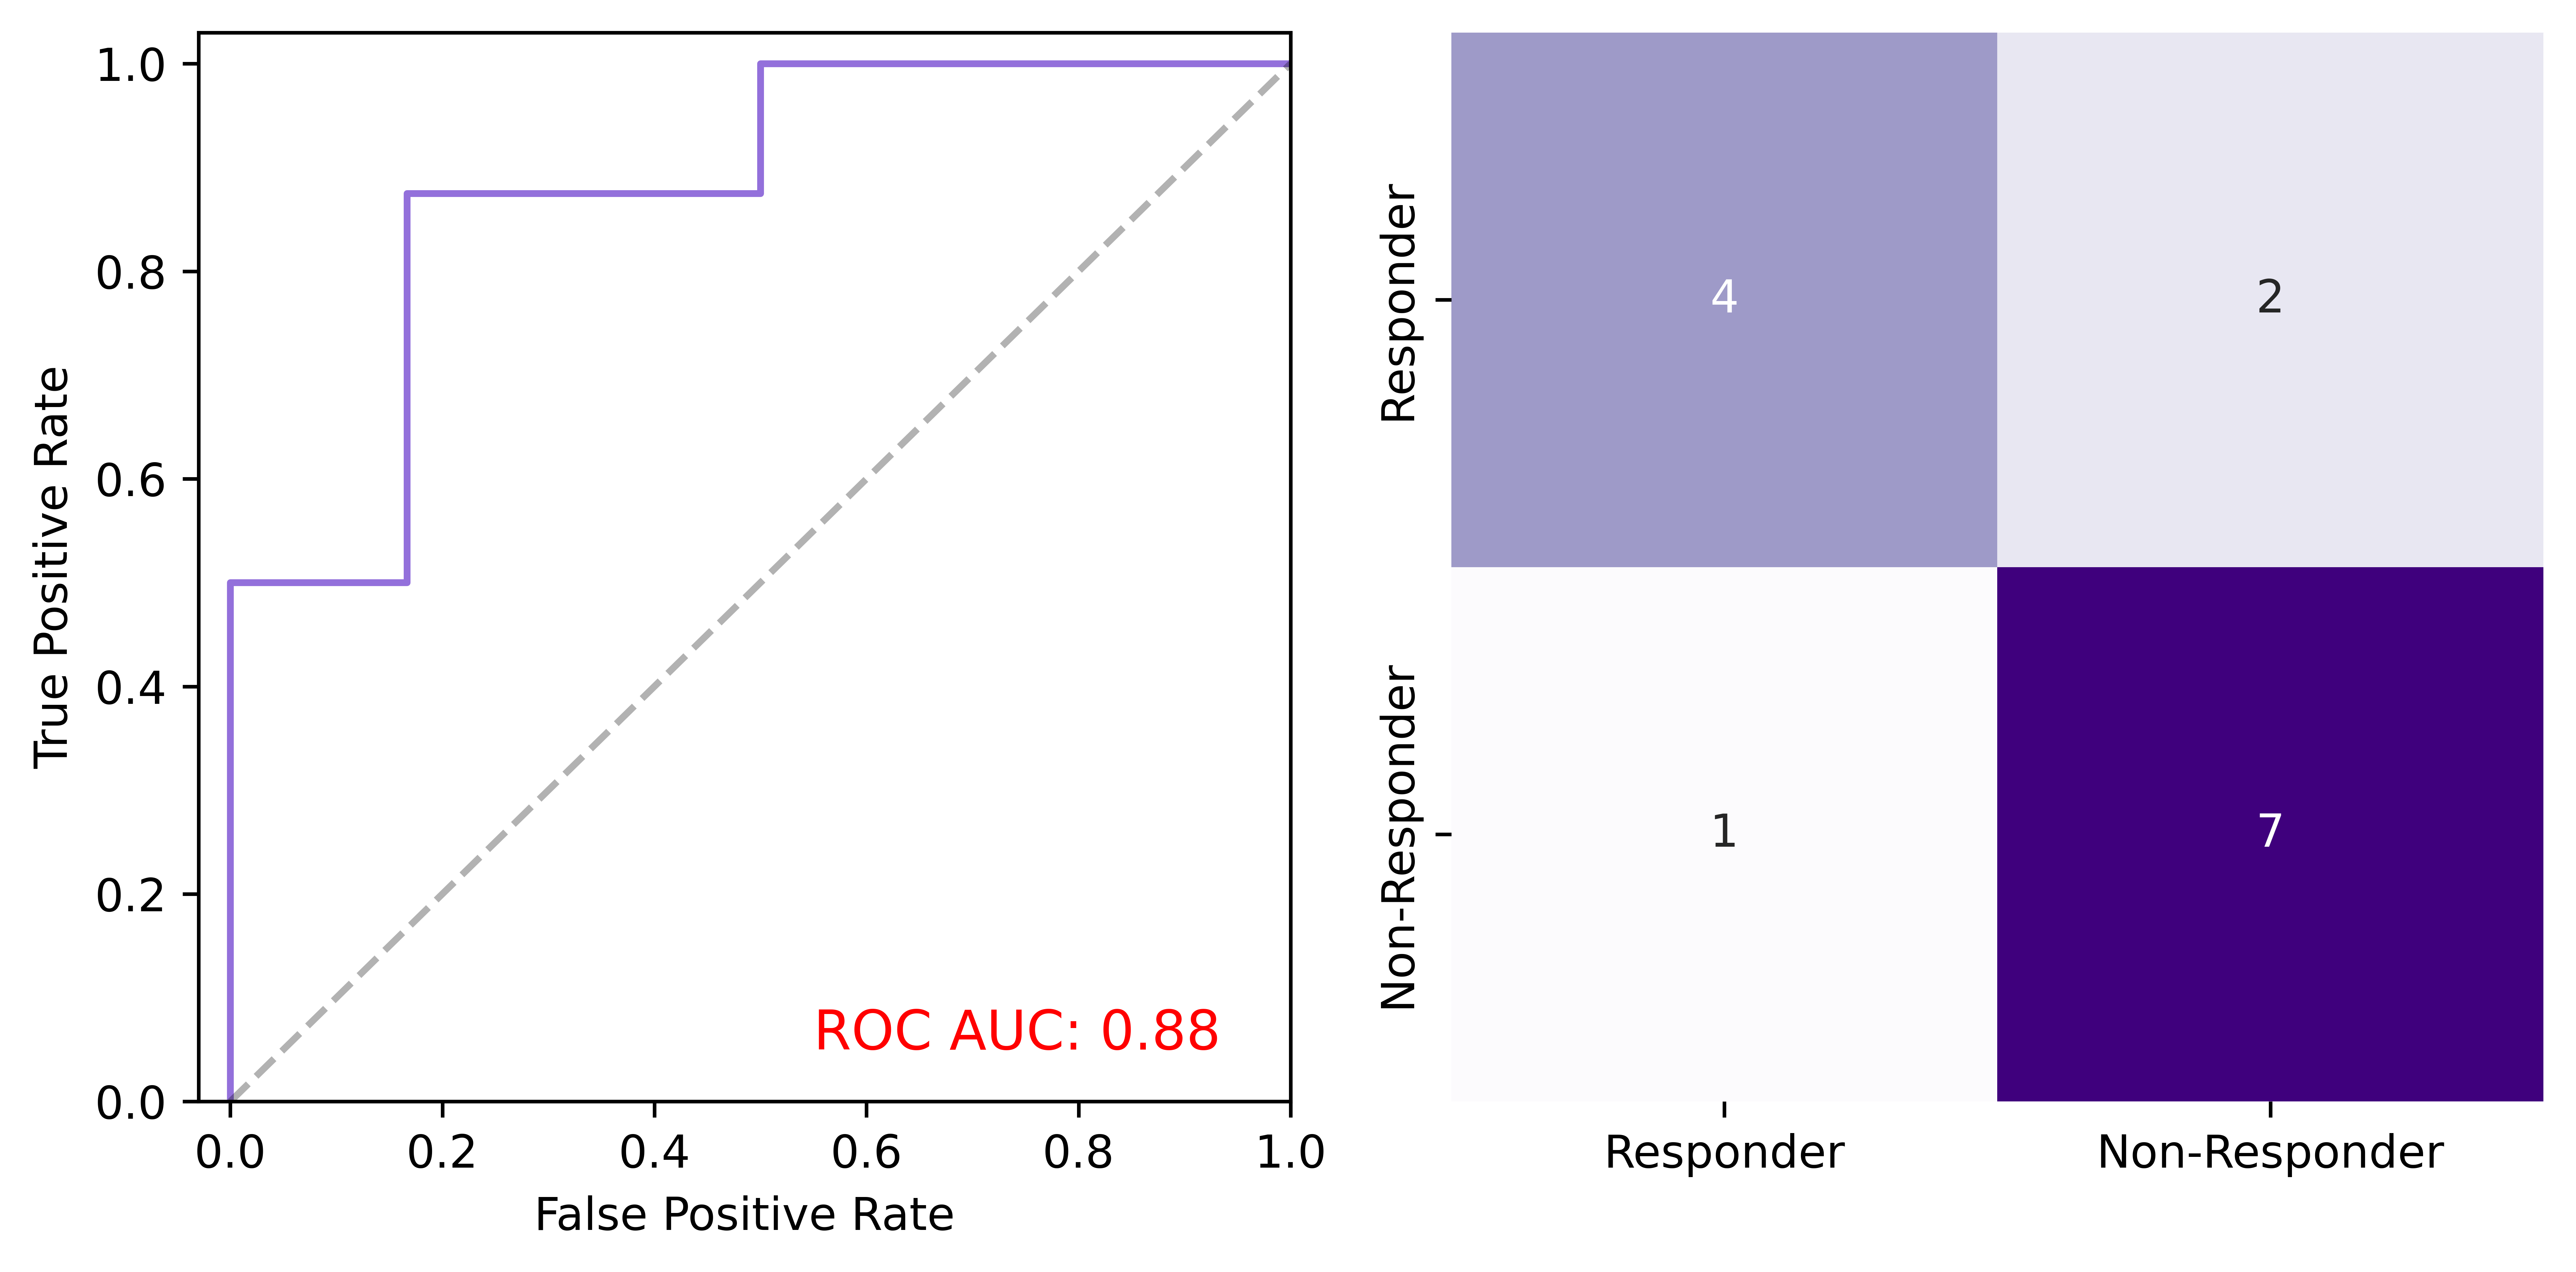

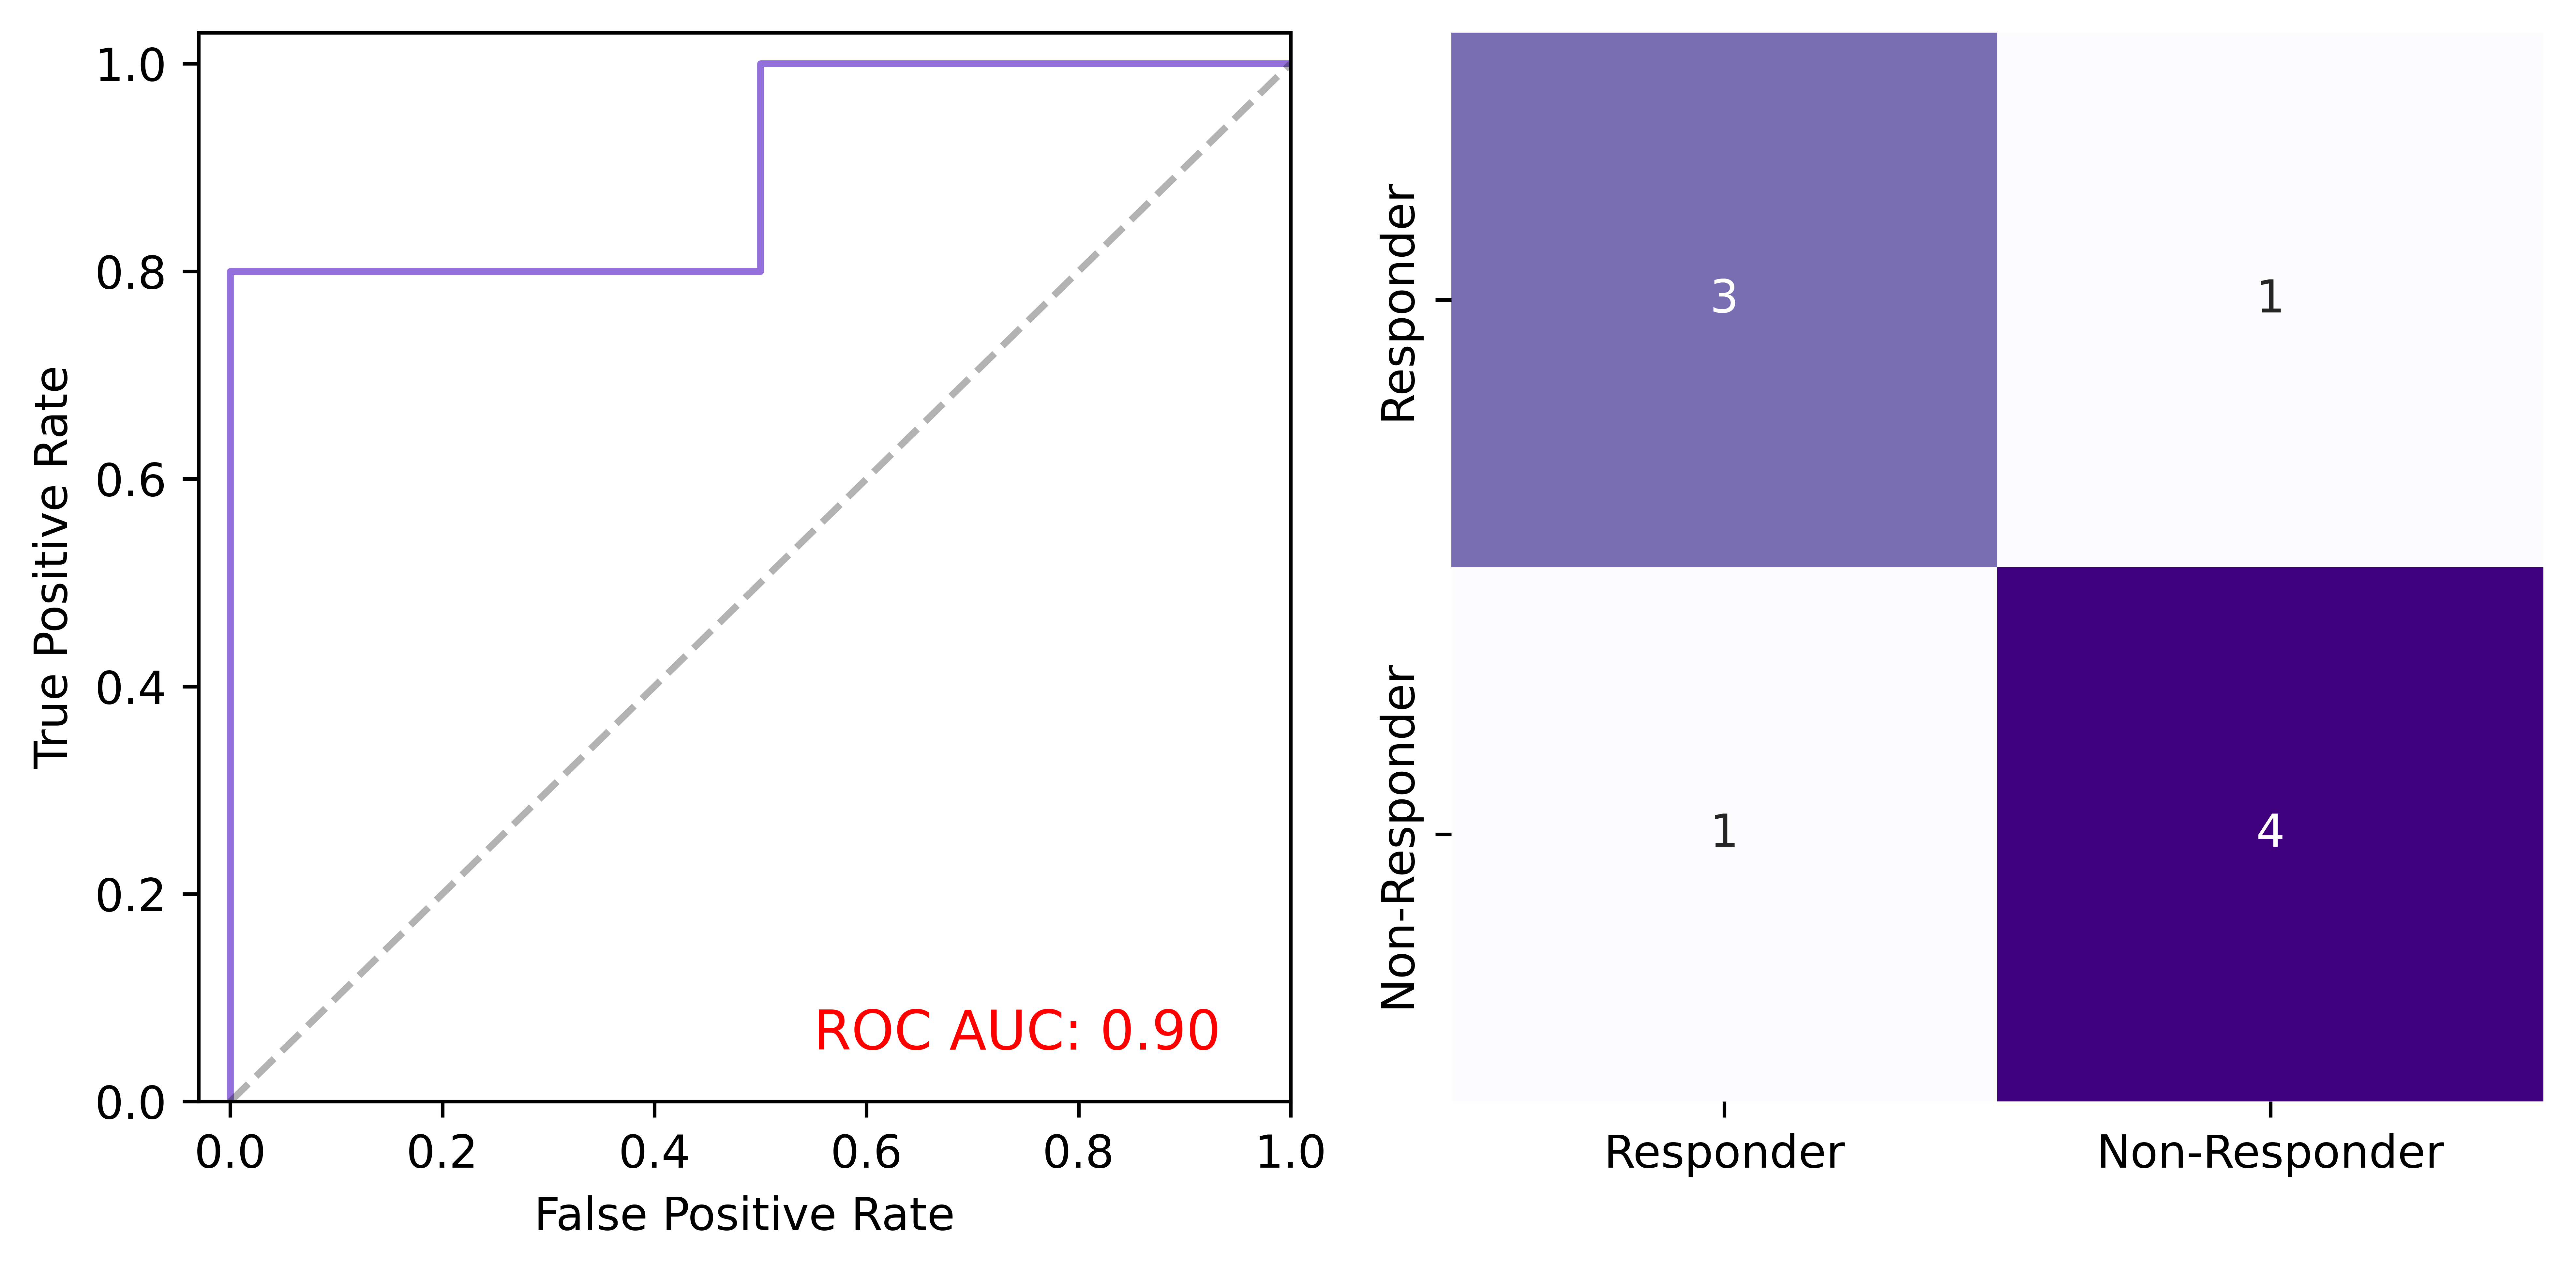

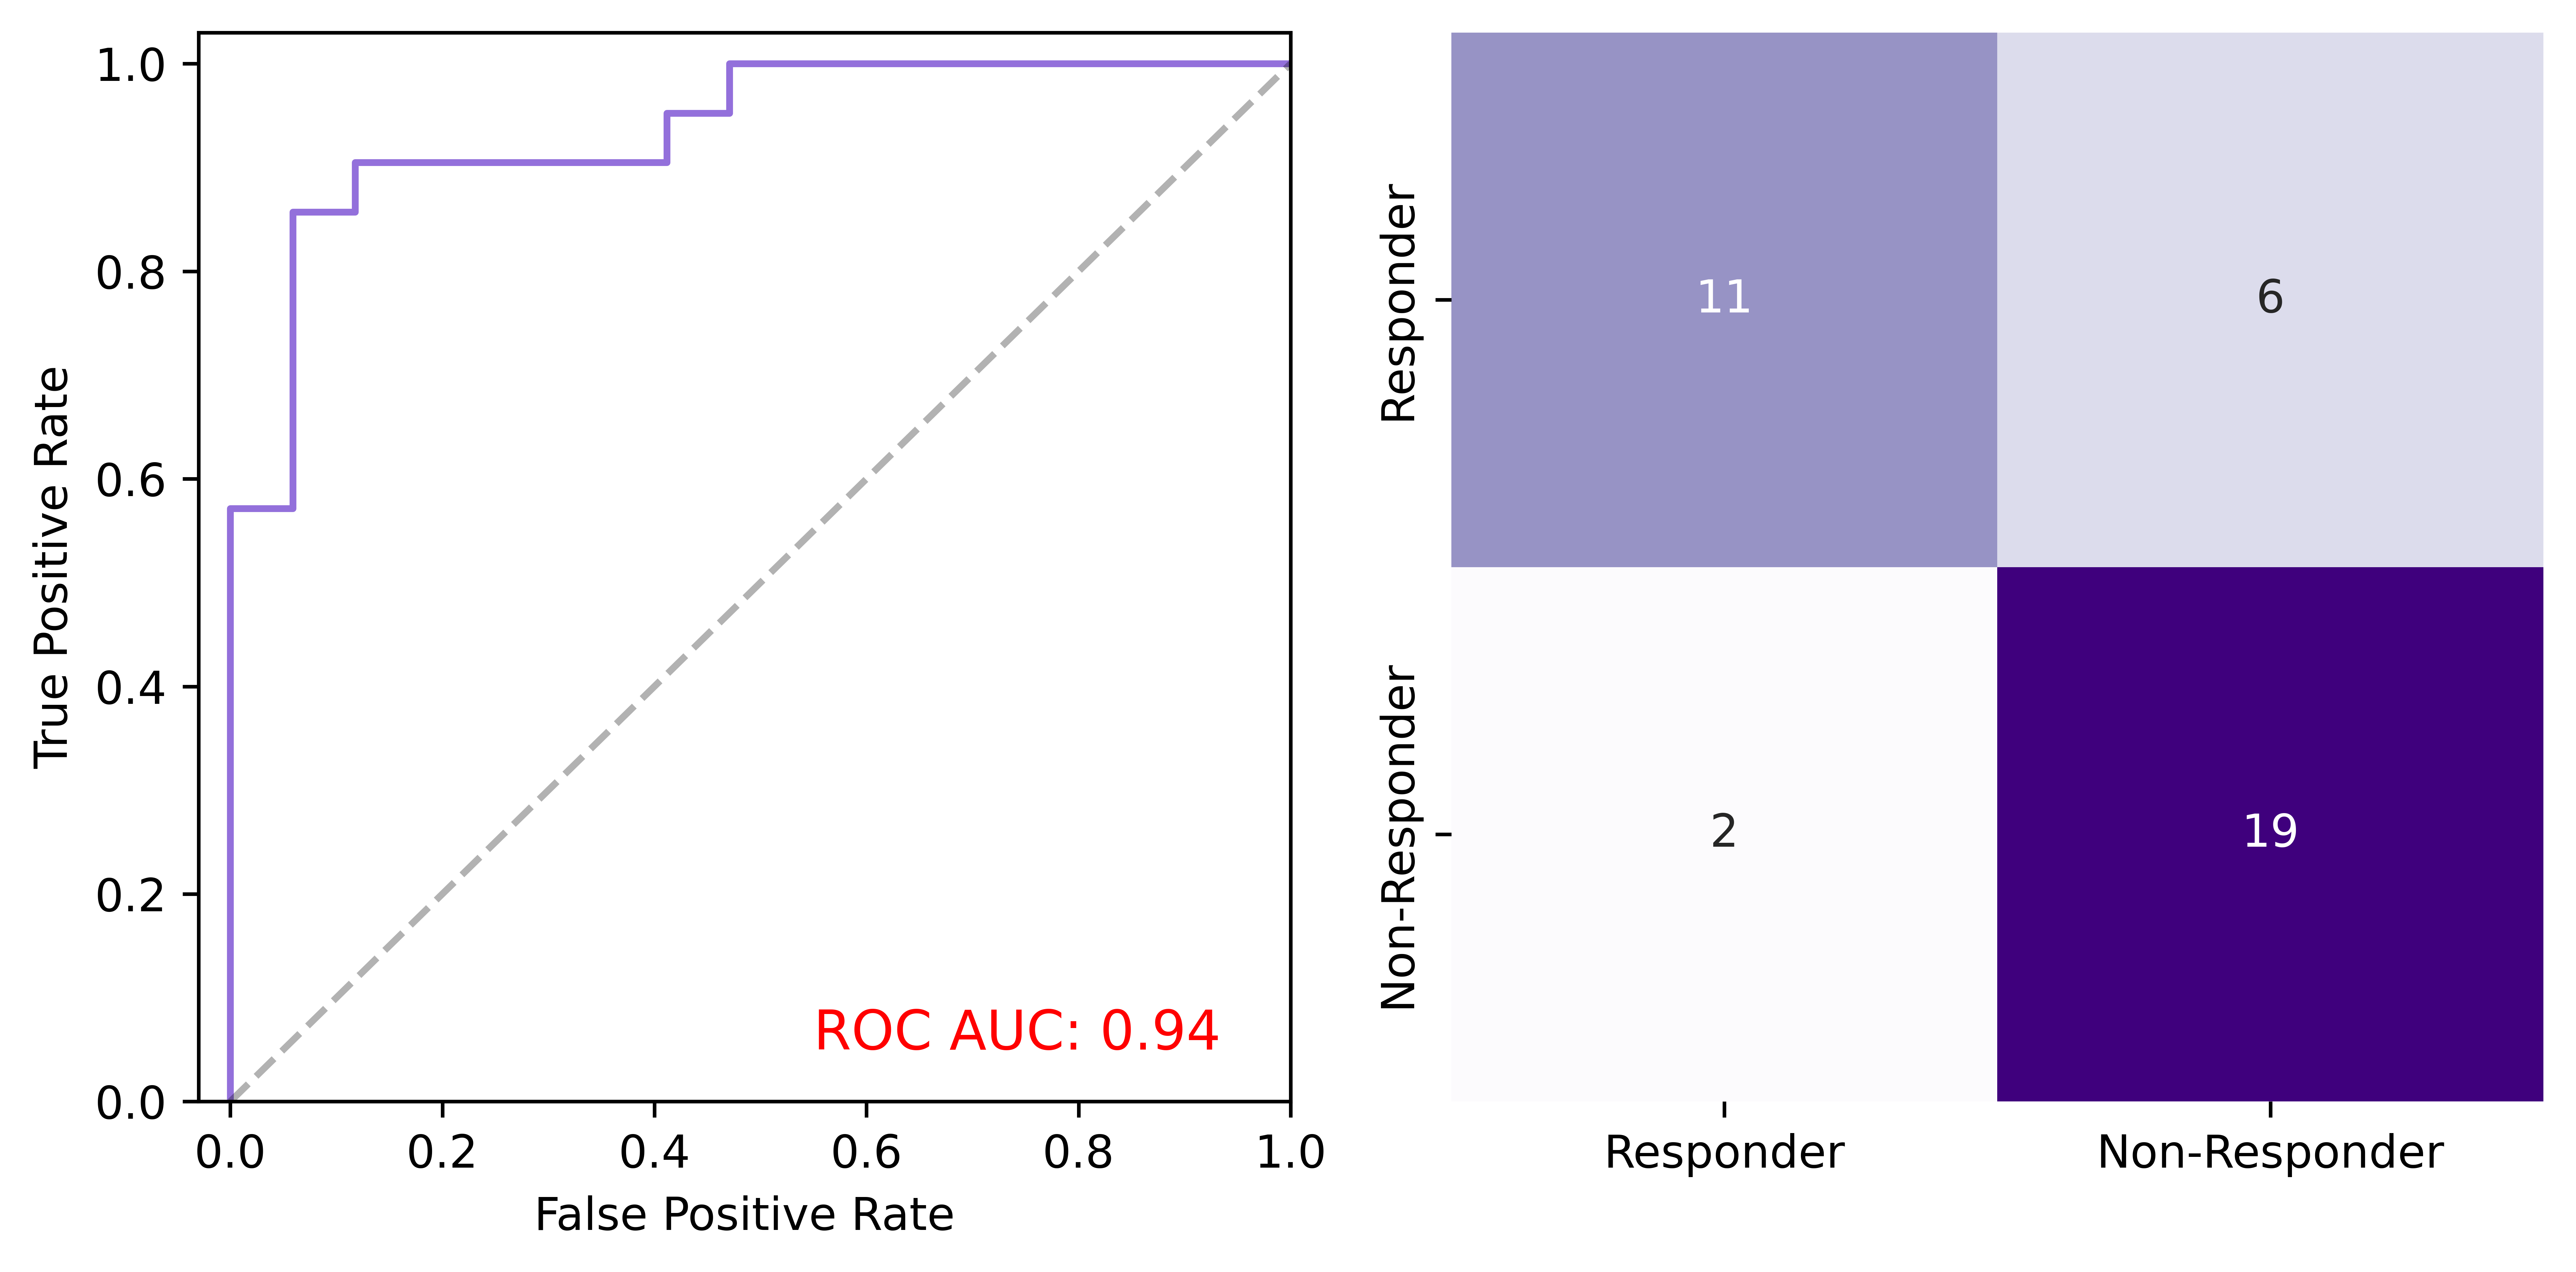

In [35]:
# plot_metrics(metrics[20], title='DELFI_Institute_Screen')
# plot_metrics(metrics[21], title='DELFI_Institute_Day0')
# plot_metrics(metrics[22], title='DELFI_Institute_AdjWk1')
# plot_metrics(metrics[23], title='DELFI_Institute_Overall')

plot_metrics(metrics[10], title='MDS_Institute_Screen')
plot_metrics(metrics[11], title='MDS_Institute_Day0')
plot_metrics(metrics[12], title='MDS_Institute_AdjWk1')
plot_metrics(metrics[13], title='MDS_Institute_Overall')

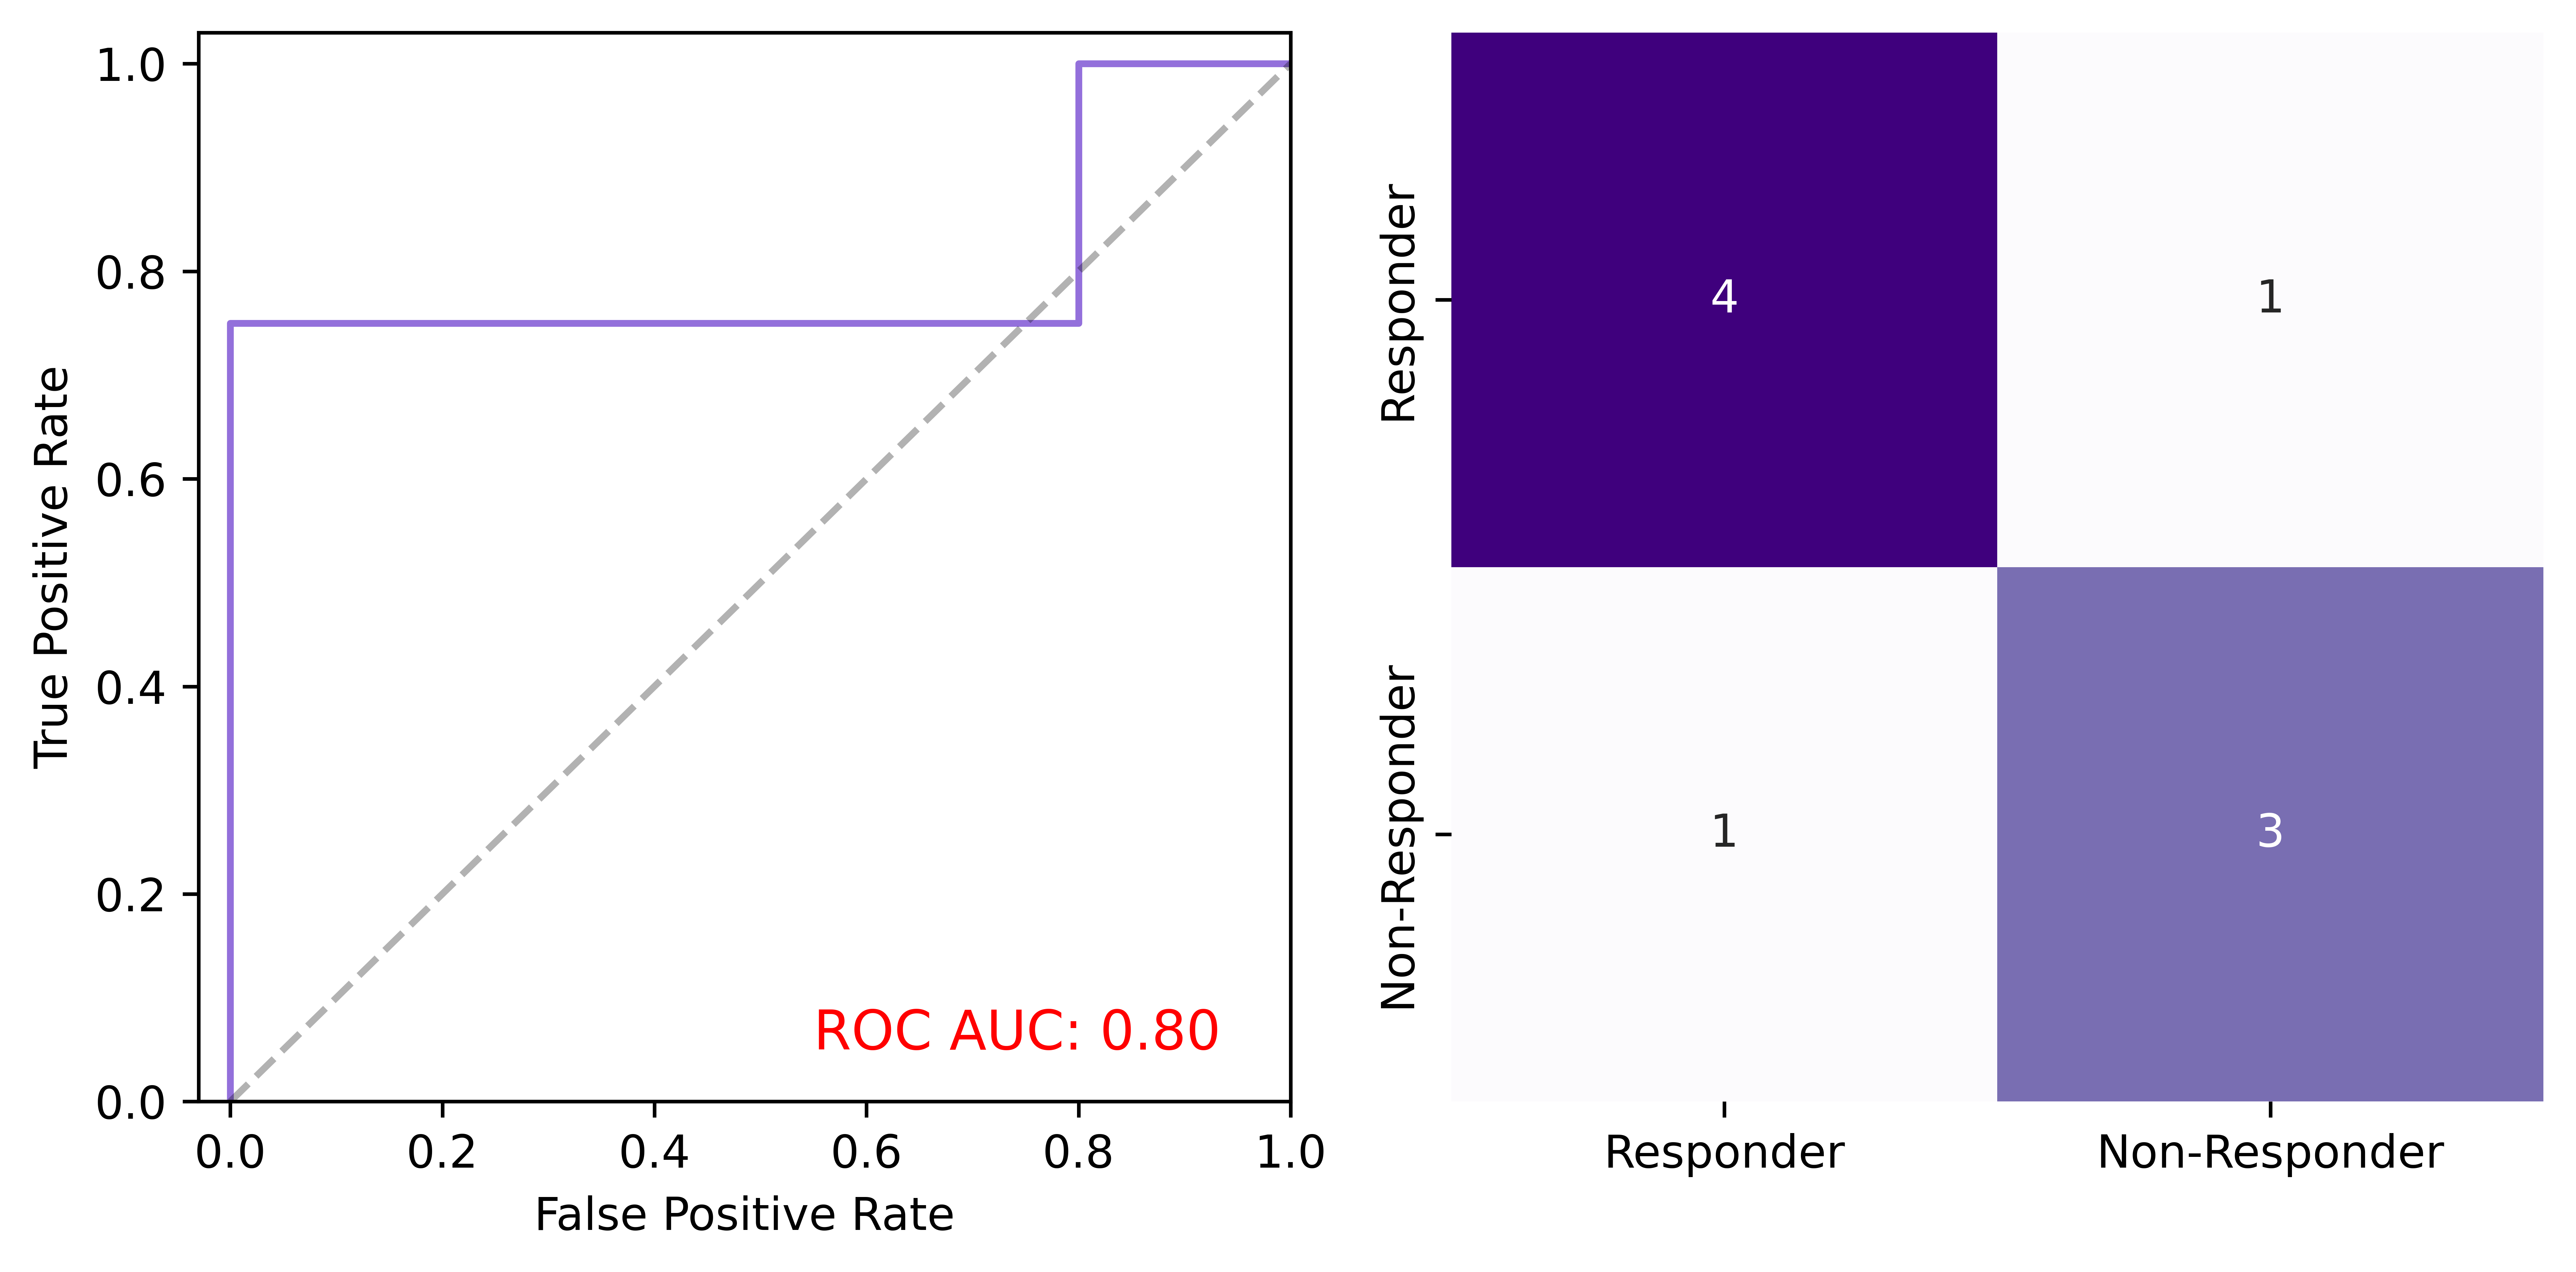

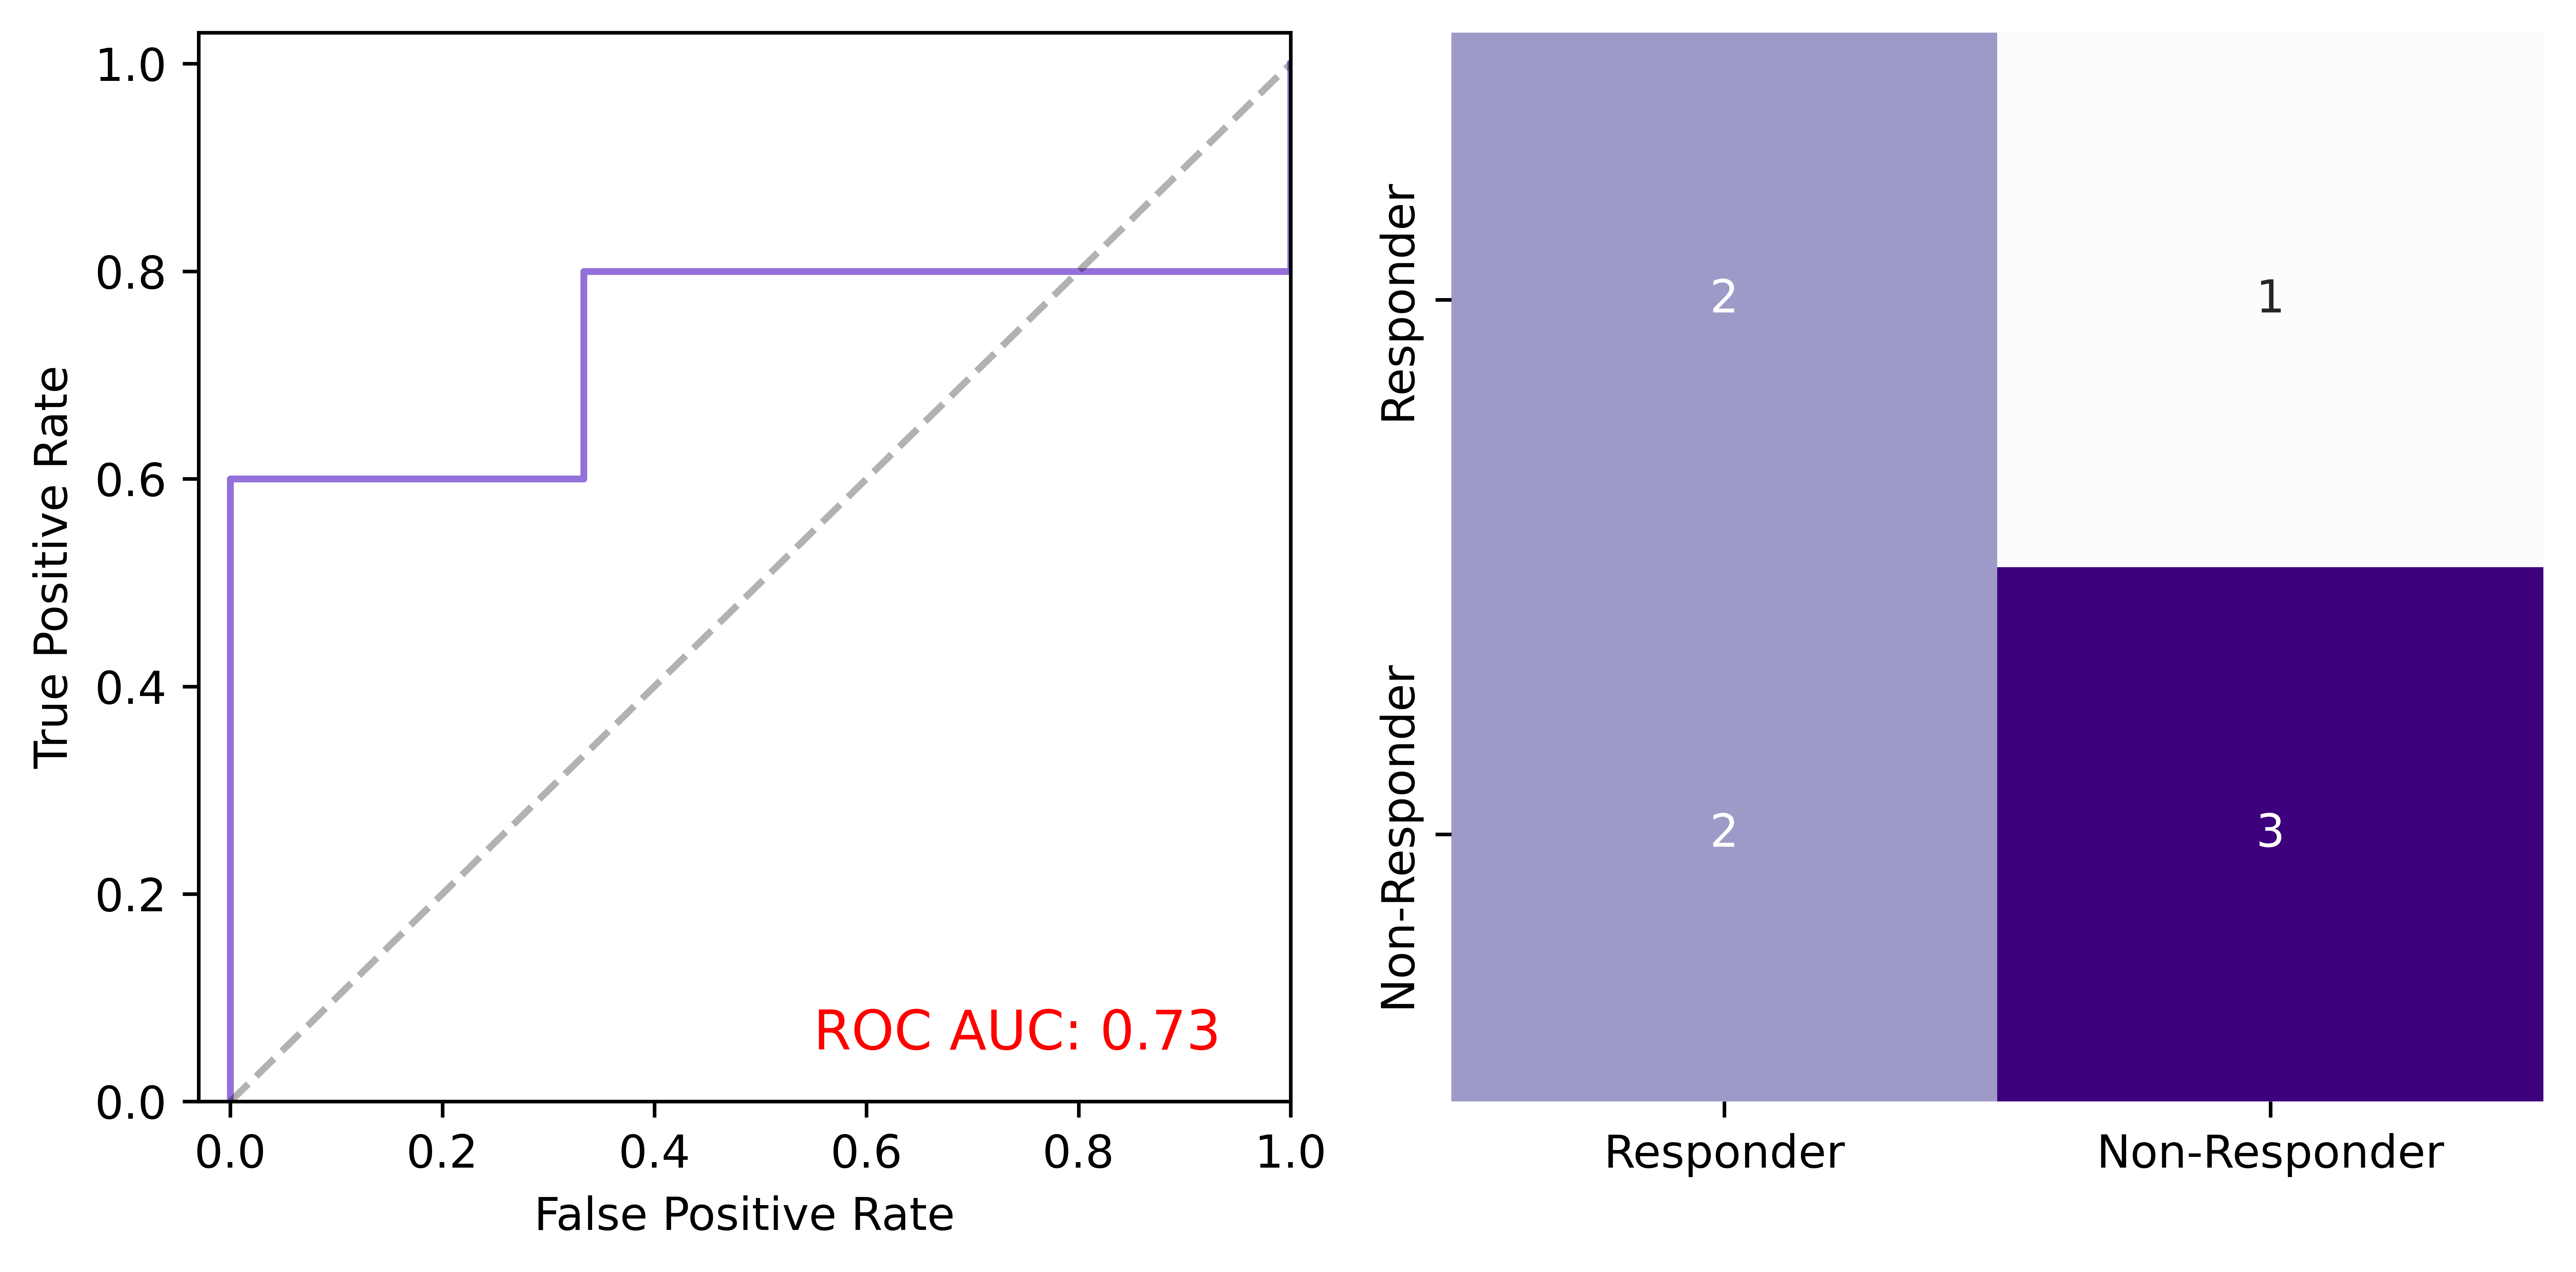

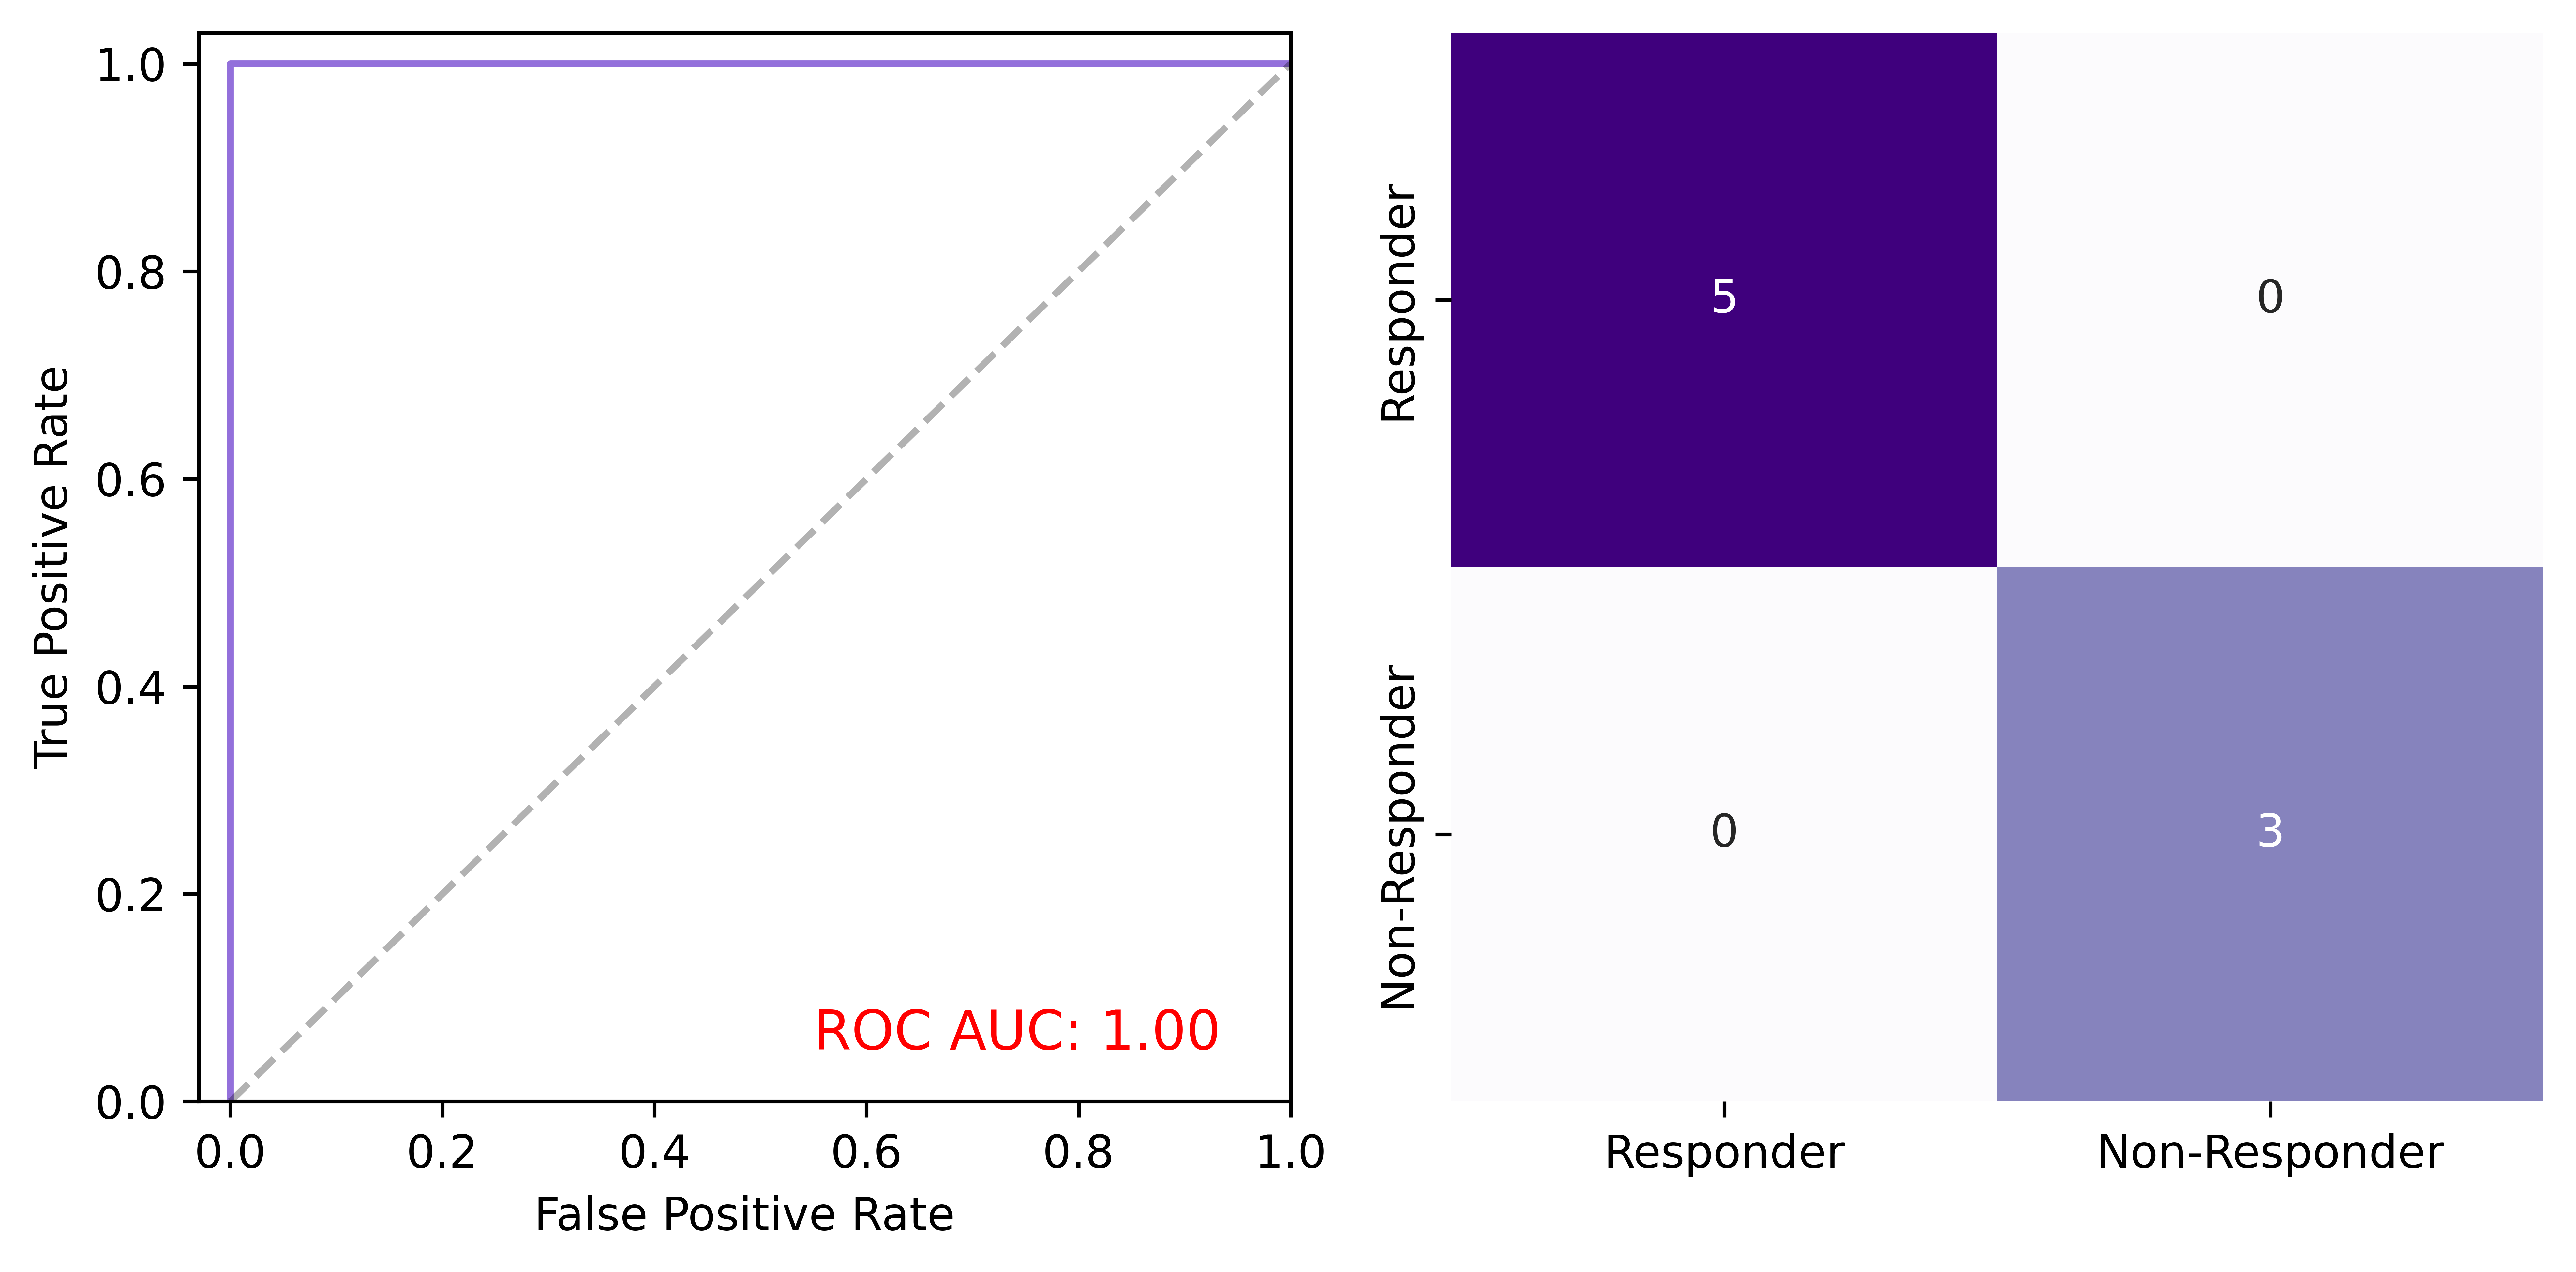

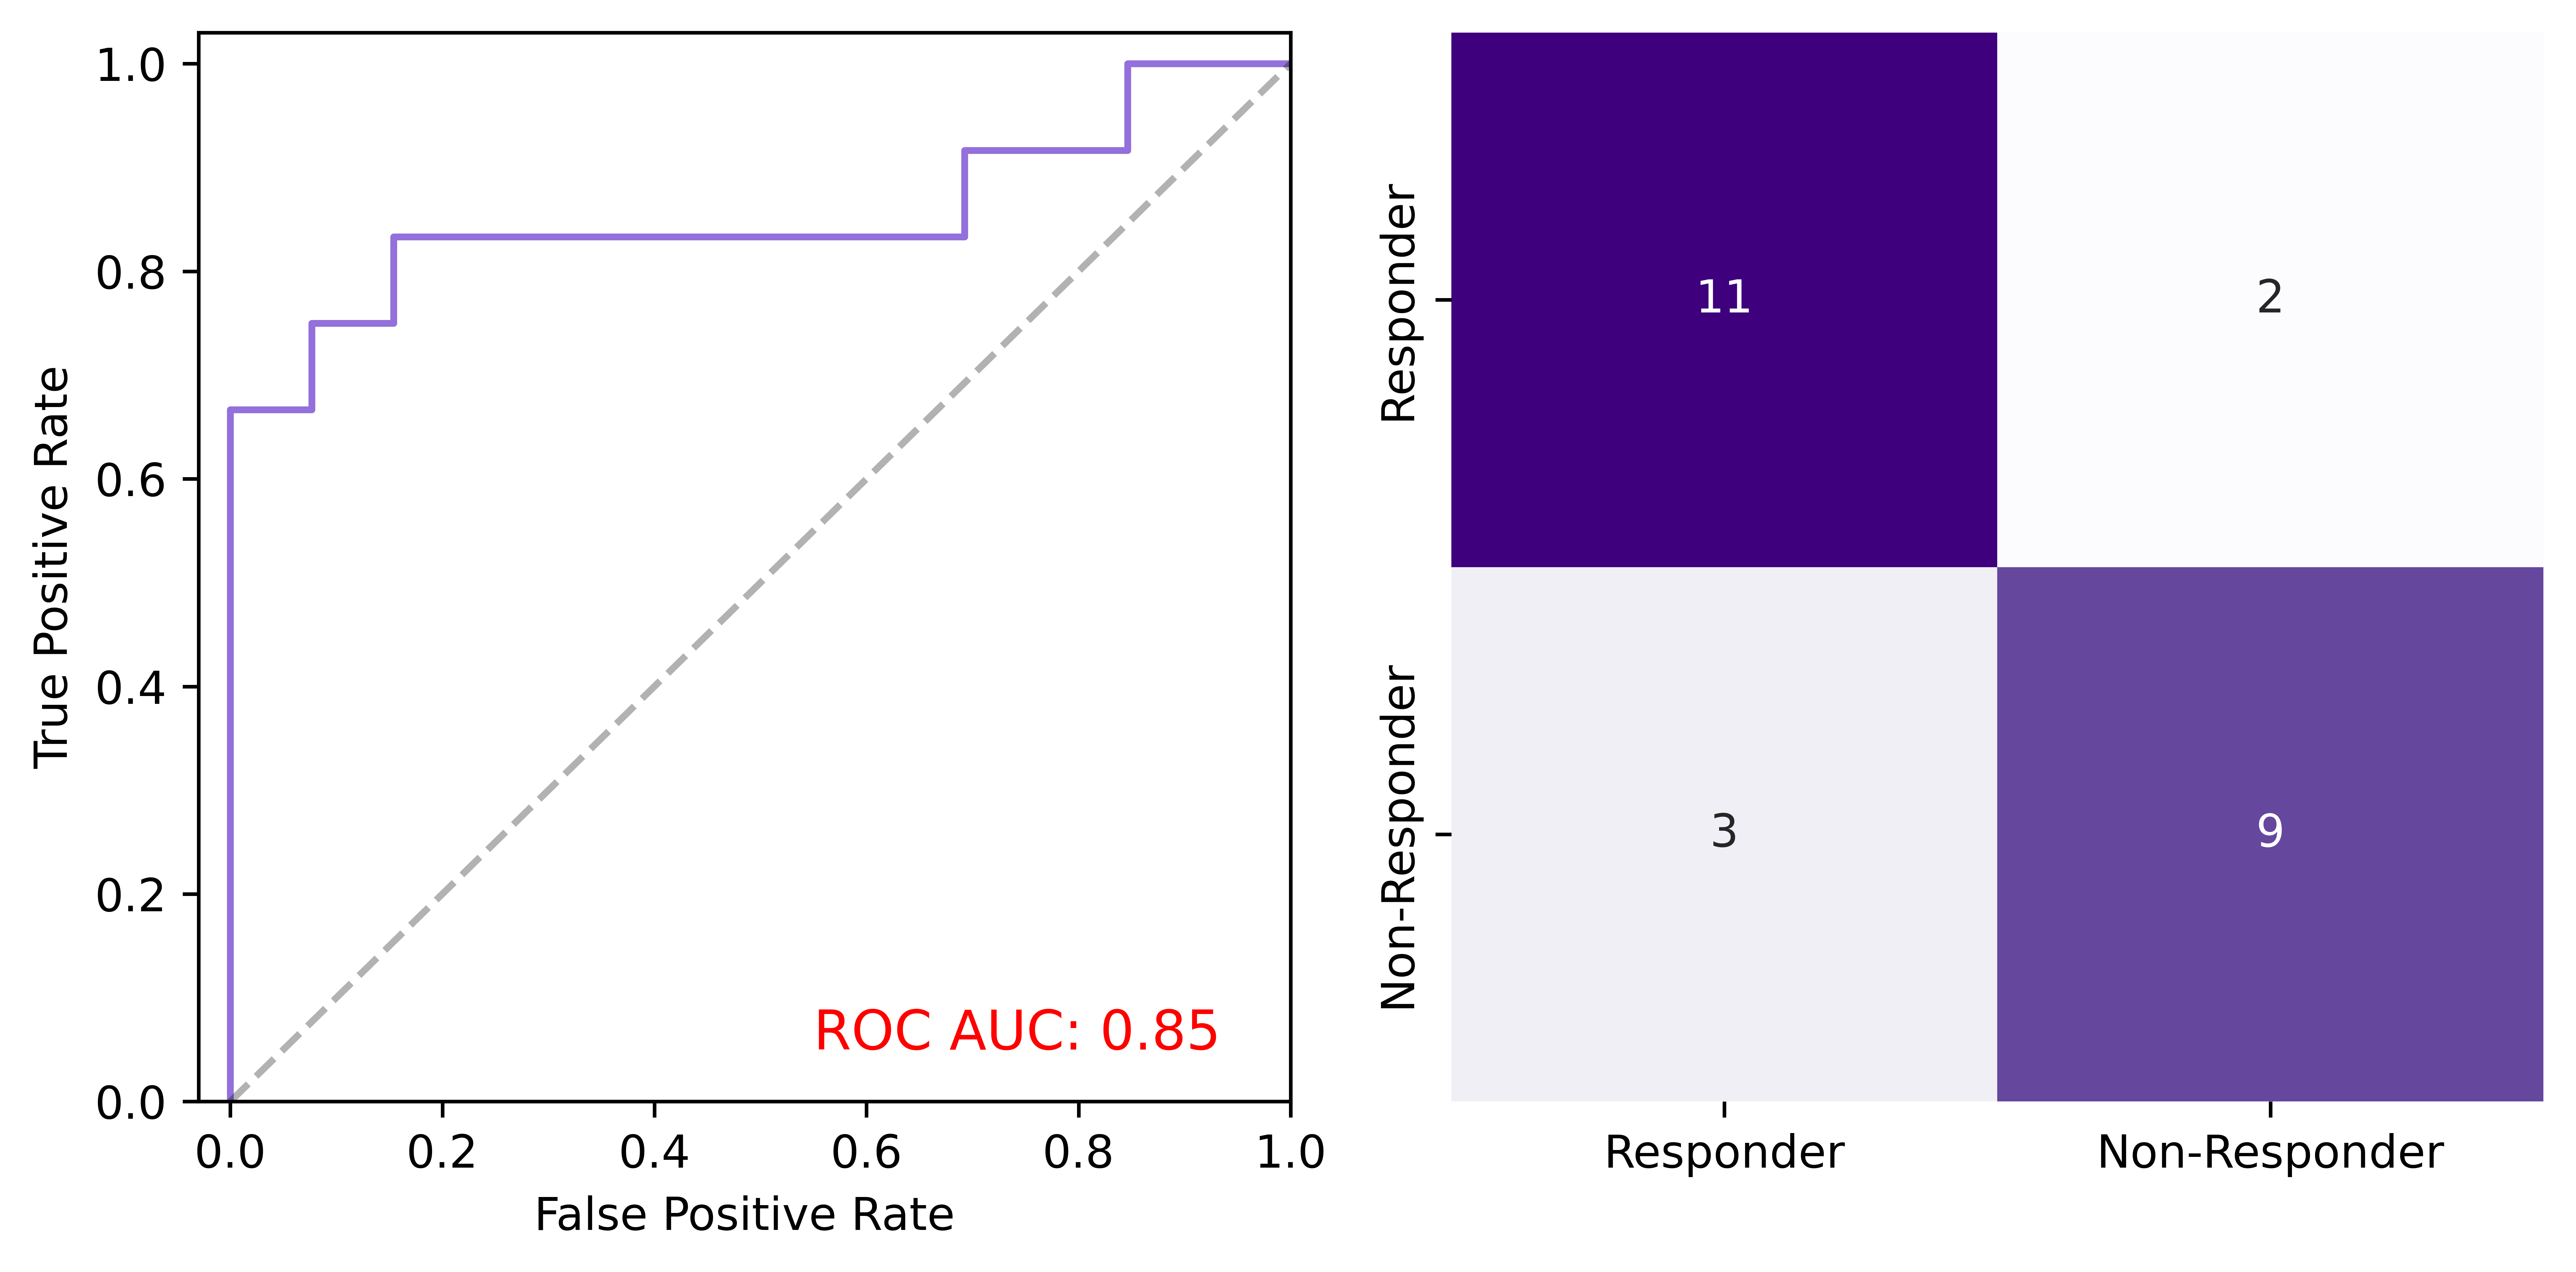

In [36]:
# plot_metrics(metrics[28], title='DELFI_Hold_Screen')
# plot_metrics(metrics[29], title='DELFI_Hold_Day0')
# plot_metrics(metrics[30], title='DELFI_Hold_AdjWk1')
# plot_metrics(metrics[31], title='DELFI_Hold_Overall')

plot_metrics(metrics[14], title='MDS_Hold_Screen')
plot_metrics(metrics[15], title='MDS_Hold_Day0')
plot_metrics(metrics[16], title='MDS_Hold_AdjWk1')
plot_metrics(metrics[17], title='MDS_Hold_Overall')

In [37]:
delfi_train_eval, mds_train_eval = eval_model(delfi_train, mds_train, delfi_svd, mds_svd, delfi_m, mds_m, "Training_Data")

df_train = pd.concat([delfi_train_eval, mds_train_eval, delfi_train['Treatment Response'], delfi_train['Patient Number'], delfi_train['Type of Visit']], axis=1)

In [38]:
train_predictions = df_train.groupby('Patient Number').apply(adjust_coefficients_mean)

In [39]:
all_predictions = pd.concat([train_predictions, institute_predictions, hold_predictions])

In [40]:
with open('treatment_response_dict.pkl', 'wb') as f:
    pickle.dump(all_predictions['Treatment Response'].to_dict(), f)

with open('predicted_treatment_response_dict.pkl', 'wb') as f:
    pickle.dump(all_predictions['Predicted Treatment Response'].to_dict(), f)

In [25]:
from itertools import combinations

# Prepare institute ID lists
institute_ids = [
    list(delfi.institute1_ids),
    list(delfi.institute2_ids),
    list(delfi.institute3_ids),
    list(delfi.institute4_ids),
    list(delfi.institute5_ids),
    list(delfi.institute6_ids),
]

# Metrics accumulators
sample_metrics = []
patient_metrics = []
hold_sample_metrics = []
hold_patient_metrics = []

def prepare_train_test(data, train_ids, test_ids):
    def build_df(ids):
        feats = data.get_raw_features(data.get_subset(ids))
        meta  = data.get_metadata_col("Treatment Response", data.get_subset(ids))
        pno   = data.get_metadata_col("Patient Number", data.get_subset(ids))
        tov   = data.get_metadata_col("Type of Visit", data.get_subset(ids))
        return pd.concat([feats, meta, pno, tov], axis=1)
    hold_df = pd.concat([
        data.get_raw_features(data.hold_data),
        data.get_metadata_col("Patient Number", data.hold_data),
        data.get_metadata_col("Type of Visit", data.hold_data),
        data.get_metadata_col("Treatment Response", data.hold_data),
    ], axis=1)
    return build_df(train_ids), build_df(test_ids), hold_df

# Loop over all 2‑institute hold‐out combinations
for test_combo in combinations(range(6), 2):
    print(test_combo)
    train_ids = sum([institute_ids[i] for i in range(6) if i not in test_combo], [])
    test_ids  = sum([institute_ids[i] for i in test_combo], [])

    # Prepare data
    d_train_df, d_test_df, d_hold_df = prepare_train_test(delfi, train_ids, test_ids)
    m_train_df, m_test_df, m_hold_df = prepare_train_test(mds,   train_ids, test_ids)

    # Train models
    svd1, svd2, m1, m2 = train_model(
        d_train_df, m_train_df,
        k_features1=10, k_features2=10,
        base_model_cls1=TabPFNClassifier,
        base_model_cls2=TabPFNClassifier,
        random_state=42
    )

    # Evaluate on institute hold‑out
    _, test_eval = eval_model(
        d_test_df, m_test_df,
        svd1, svd2, m1, m2,
        name=f"MDS_InstituteHoldOut_{test_combo}"
    )
    df_sample = pd.concat([
        test_eval,
        d_test_df['Treatment Response'],
        d_test_df['Patient Number'],
        d_test_df['Type of Visit']
    ], axis=1)

    # --- PATIENT MEAN aggregation ---
    df_pat_mean = df_sample.groupby('Patient Number', as_index=False).agg(
        mds=('mds','mean'),
        Treatment_Response=('Treatment Response','first')
    )
    y_true  = (df_pat_mean['Treatment_Response']=='Responder').values
    y_score = df_pat_mean['mds'].values
    y_pred  = y_score > 0.5
    fpr, tpr, _ = roc_curve(y_true, y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False,True]).ravel()
    patient_metrics.append({
        'Aggregation':'Mean','Level':'patient','Type':'Institute',
        'Holdout Institutes': f"{test_combo[0]+1},{test_combo[1]+1}",
        'Visit':'Overall','ROC_AUC':roc_auc_score(y_true,y_score),
        'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
        'FPR':fpr.tolist(),'TPR':tpr.tolist(),'tp':tp,'tn':tn,'fp':fp,'fn':fn
    })

    # --- PATIENT PRIORITY aggregation (Adj Wk 1 only) ---
    has_adj = ~df_sample.groupby('Patient Number')['Type of Visit'] \
                   .transform(lambda v: v.eq('Adj Wk 1').any())
    
    df_prio = df_sample[has_adj]
    df_prio = df_sample[df_sample['Type of Visit'] != 'Adj Wk 1']

    if not df_prio.empty:
        df_pat_prio = df_prio.groupby('Patient Number', as_index=False).agg(
            mds=('mds', 'mean'),
            Treatment_Response=('Treatment Response', 'first')
        )
        y_true  = (df_pat_prio['Treatment_Response']=='Responder').values
        y_score = df_pat_prio['mds'].values
        y_pred  = y_score > 0.5
    
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False, True]).ravel()
    
        patient_metrics.append({
            'Aggregation':'Priority',
            'Level':'patient',
            'Type':'Institute',
            'Holdout Institutes': f"{test_combo[0]+1},{test_combo[1]+1}",
            'Visit':'Overall',
            'ROC_AUC': roc_auc_score(y_true, y_score),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred),
            'FPR': fpr.tolist(),
            'TPR': tpr.tolist(),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        })

    # --- SAMPLE‑LEVEL metrics ---
    for visit in ['Screen','Day 0','Adj Wk 1','Overall']:
        preds = df_sample if visit=='Overall' else df_sample[df_sample['Type of Visit']==visit]
        if preds.empty:
            continue
        y_true = (preds['Treatment Response']=='Responder').values
        y_score= preds['mds'].values
        y_pred = y_score > 0.5
        fpr, tpr, th = roc_curve(y_true,y_score)
        tn, fp, fn, tp = confusion_matrix(y_true,y_pred,labels=[False,True]).ravel()
        sample_metrics.append({
            'Level':'sample','Type':'Institute',
            'Holdout Institutes':f"{test_combo[0]+1},{test_combo[1]+1}",
            'Visit':visit,'ROC_AUC':roc_auc_score(y_true,y_score),
            'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
            'FPR':fpr.tolist(),'TPR':tpr.tolist(),'Thresholds':th.tolist(),
            'tp':tp,'tn':tn,'fp':fp,'fn':fn
        })

    # --- PRE‑HOLDOUT evaluation ---
    _, hold_eval = eval_model(
        d_hold_df, m_hold_df,
        svd1, svd2, m1, m2,
        name=f"MDS_PreHoldout_{test_combo}"
    )
    df_hold_sample = pd.concat([
        hold_eval,
        m_hold_df['Treatment Response'],
        m_hold_df['Patient Number'],
        m_hold_df['Type of Visit']
    ], axis=1)

    # holdout sample‑level metrics
    for visit in ['Screen','Day 0','Adj Wk 1','Overall']:
        preds = df_hold_sample if visit=='Overall' else df_hold_sample[df_hold_sample['Type of Visit']==visit]
        if preds.empty:
            continue
        y_true = (preds['Treatment Response']=='Responder').values
        y_score= preds['mds'].values
        y_pred = y_score > 0.5
        fpr, tpr, th = roc_curve(y_true,y_score)
        tn, fp, fn, tp = confusion_matrix(y_true,y_pred,labels=[False,True]).ravel()
        hold_sample_metrics.append({
            'Level':'sample','Type':'PreHold',
            'Holdout Institutes':f"{test_combo[0]+1},{test_combo[1]+1}",
            'Visit':visit,'ROC_AUC':roc_auc_score(y_true,y_score),
            'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
            'FPR':fpr.tolist(),'TPR':tpr.tolist(),'Thresholds':th.tolist(),
            'tp':tp,'tn':tn,'fp':fp,'fn':fn
        })

    # holdout PATIENT MEAN aggregation
    df_hp_mean = df_hold_sample.groupby('Patient Number', as_index=False).agg(
        mds=('mds','mean'),
        Treatment_Response=('Treatment Response','first')
    )
    y_true  = (df_hp_mean['Treatment_Response']=='Responder').values
    y_score = df_hp_mean['mds'].values
    y_pred  = y_score > 0.5
    fpr, tpr, _ = roc_curve(y_true, y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False,True]).ravel()
    hold_patient_metrics.append({
        'Aggregation':'Mean','Level':'patient','Type':'PreHold',
        'Holdout Institutes': f"{test_combo[0]+1},{test_combo[1]+1}",
        'Visit':'Overall','ROC_AUC':roc_auc_score(y_true,y_score),
        'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
        'FPR':fpr.tolist(),'TPR':tpr.tolist(),'tp':tp,'tn':tn,'fp':fp,'fn':fn
    })

    # holdout PATIENT PRIORITY aggregation

    has_hold_adj = df_hold_sample.groupby('Patient Number')['Type of Visit'] \
                   .transform(lambda v: v.eq('Adj Wk 1').any())
    
    # select _all_ hold‐out samples for those patients
    df_hold_prio = df_hold_sample[has_hold_adj]
    df_hold_prio = df_hold_sample[df_hold_sample['Type of Visit'] != 'Adj Wk 1']

    if not df_hold_prio.empty:
        df_hp_prio = df_hold_prio.groupby('Patient Number', as_index=False).agg(
            mds=('mds', 'mean'),
            Treatment_Response=('Treatment Response', 'first')
        )
        y_true  = (df_hp_prio['Treatment_Response'] == 'Responder').values
        y_score = df_hp_prio['mds'].values
        y_pred  = y_score > 0.5
    
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False, True]).ravel()
    
        hold_patient_metrics.append({
            'Aggregation': 'Priority',
            'Level':       'patient',
            'Type':        'PreHold',
            'Holdout Institutes': f"{test_combo[0]+1},{test_combo[1]+1}",
            'Visit':       'Overall',
            'ROC_AUC':     roc_auc_score(y_true, y_score),
            'Accuracy':    accuracy_score(y_true, y_pred),
            'F1':          f1_score(y_true, y_pred),
            'FPR':         fpr.tolist(),
            'TPR':         tpr.tolist(),
            'tp':          tp,
            'tn':          tn,
            'fp':          fp,
            'fn':          fn
        })

# Save metrics to CSV
pd.DataFrame(sample_metrics).to_csv("MDS_Sample_Level_Metrics_REPINST.csv", index=False)
pd.DataFrame(patient_metrics).to_csv("MDS_Patient_Level_Metrics_REPINST.csv", index=False)
pd.DataFrame(hold_sample_metrics).to_csv("MDS_Holdout_Sample_Level_REPINST.csv", index=False)
pd.DataFrame(hold_patient_metrics).to_csv("MDS_Holdout_Patient_Level_REPINST.csv", index=False)

# Plotting function with row‑normalized per-prediction percentages
def plot_metrics_by_visit(df_all, visit, title=''):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    df_visit = df_all[df_all['Visit'] == visit]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    # ROC panel
    ax1 = axes[0]
    for _, row in df_visit.iterrows():
        ax1.plot(row['FPR'], row['TPR'], alpha=0.05, linewidth=1, color='gray')
    mean_fpr = np.linspace(0, 1, 100)
    all_interp = [np.interp(mean_fpr, row['FPR'], row['TPR']) for _, row in df_visit.iterrows()]
    mean_tpr = np.mean(all_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = df_visit['ROC_AUC'].mean()
    ax1.plot(mean_fpr, mean_tpr, linewidth=2, color='mediumpurple', label=f'Mean ROC (AUC = {mean_auc:.2f})')
    ax1.plot([0, 1], [0, 1], linestyle='--', alpha=0.5, color='gray')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{visit} ROC Curves')
    ax1.legend()

    # Confusion-matrix panel
    percent_cms = []
    for _, row in df_visit.iterrows():
        cm = np.array([[row['tn'], row['fp']],
                       [row['fn'], row['tp']]], dtype=float)
        cm_norm = (cm / cm.sum()) * 100
        percent_cms.append(cm_norm)

    percent_cms = np.array(percent_cms)
    mean_cm = np.nanmean(percent_cms, axis=0)
    std_cm = np.nanstd(percent_cms, axis=0)

    labels = np.empty(mean_cm.shape, dtype=object)
    for i in range(2):
        for j in range(2):
            labels[i, j] = f"{mean_cm[i, j]:.1f}%\n±{std_cm[i, j]:.1f}%"

    sns.heatmap(
        mean_cm,
        annot=labels,
        fmt='',
        cmap='Purples',
        cbar=False,
        xticklabels=['Non-Responder', 'Responder'],
        yticklabels=['Non-Responder', 'Responder'],
        ax=axes[1]
    )
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_title(f'{visit} Mean ± SD Confusion Matrix (%)')

    fig.tight_layout()
    fig.savefig(f'{title}_{visit}.pdf')
    plt.close(fig)


# Generate plots for sample‑level
for visit in ['Overall','Screen','Day 0','Adj Wk 1']:
    plot_metrics_by_visit(pd.DataFrame(sample_metrics), visit, title='MDS_Institute_Sample_REPINST')
    plot_metrics_by_visit(pd.DataFrame(hold_sample_metrics), visit, title='MDS_Holdout_Sample_REPINST')

# Generate plots for patient‑level, both Mean and Priority
df_pat = pd.DataFrame(patient_metrics)
for agg in ['Mean','Priority']:
    df_agg = df_pat[df_pat['Aggregation']==agg]
    plot_metrics_by_visit(df_agg, 'Overall',
                          title=f'MDS_Institute_Patient_{agg}_REPINST')

df_hold_pat = pd.DataFrame(hold_patient_metrics)
for agg in ['Mean','Priority']:
    df_agg = df_hold_pat[df_hold_pat['Aggregation']==agg]
    plot_metrics_by_visit(df_agg, 'Overall',
                          title=f'MDS_Holdout_Patient_{agg}_REPINST')


(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)


In [27]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix

# Accumulators for metrics
sample_metrics = []
patient_metrics = []
hold_sample_metrics = []
hold_patient_metrics = []

# Helper to build train/test/hold DataFrames
def prepare_train_test(data, train_ids, test_ids):
    def build_df(ids):
        feats = data.get_raw_features(data.get_subset(ids))
        meta  = data.get_metadata_col("Treatment Response", data.get_subset(ids))
        pno   = data.get_metadata_col("Patient Number", data.get_subset(ids))
        tov   = data.get_metadata_col("Type of Visit", data.get_subset(ids))
        return pd.concat([feats, meta, pno, tov], axis=1)

    hold_df = pd.concat([
        data.get_raw_features(data.hold_data),
        data.get_metadata_col("Patient Number", data.hold_data),
        data.get_metadata_col("Type of Visit", data.hold_data),
        data.get_metadata_col("Treatment Response", data.hold_data)
    ], axis=1)

    return build_df(train_ids), build_df(test_ids), hold_df

# Fixed train/test split by institute IDs
train_ids = (
    list(delfi.institute1_ids) +
    list(delfi.institute2_ids) +
    list(delfi.institute3_ids) +
    list(delfi.institute4_ids)
)
test_ids = list(delfi.institute5_ids) + list(delfi.institute6_ids)

# Generate 100 reproducible random patient‐holdout lists
def generate_random_lists(num_lists, seed=42):
    random.seed(seed)
    return [random.sample(range(1, 69), 10) for _ in range(num_lists)]

lists = generate_random_lists(100)

# Define priority order for visits (unused now)
visit_priority = {'Screen': 0, 'Day 0': 1, 'Adj Wk 1': 2}

# Main repeat loop
for i in tqdm(range(100), desc="Repeats"):
    patient_list = lists[i]

    # loader that splits on this random patient_list
    def load_feature(path, idx, val, zscore=True, batch=True):
        f = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
        f.load_feature_to_dataframe(path, idx, val)
        f.normalize_zscore()
        f.merge_feature_metadata()
        some_data = pd.concat([f.data, f.hold_data])
        f.hold_data = some_data[some_data["Patient Number"].isin(patient_list)]
        f.data      = some_data[~some_data["Patient Number"].isin(patient_list)]
        if batch: f.batch_correct()
        return f

    delfi = load_feature("/projects/b1198/epifluidlab/ravi/0401/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 12)
    mds = load_feature("/projects/b1198/epifluidlab/ravi/0401/headneck/data/hg38_frag_filtered/*.hg38.frag.interval_mds.tsv", 0, 4)

    d_train_df, d_test_df, d_hold_df = prepare_train_test(delfi, train_ids, test_ids)
    m_train_df, m_test_df, m_hold_df = prepare_train_test(mds,   train_ids, test_ids)

    skip = False
    for df, name in [(d_train_df,'train'), (d_test_df,'test'), (d_hold_df,'hold')]:
        if df['Treatment Response'].nunique() < 2:
            skip = True; break
    if skip: continue

    for df in [d_test_df, d_hold_df]:
        for visit in ['Screen','Day 0','Adj Wk 1']:
            sub = df[df['Type of Visit']==visit]
            if not sub.empty and sub['Treatment Response'].nunique()<2:
                skip = True; break
        if skip: break
    if skip: continue

    svd1, svd2, m1, m2 = train_model(
        d_train_df, m_train_df,
        k_features1=10, k_features2=10,
        base_model_cls1=TabPFNClassifier,
        base_model_cls2=TabPFNClassifier,
        random_state=42
    )

    _, test_eval = eval_model(
        d_test_df, m_test_df, svd1, svd2, m1, m2,
        name=f"MDS_InstituteRepeat_{i}"
    )
    df_sample = pd.concat([
        test_eval,
        d_test_df['Treatment Response'],
        d_test_df['Patient Number'],
        d_test_df['Type of Visit']
    ], axis=1)

    # Patient‐level MEAN aggregation
    df_pat_mean = df_sample.groupby('Patient Number', as_index=False).agg(
        mds=('mds','mean'),
        Treatment_Response=('Treatment Response','first')
    )
    y_true  = (df_pat_mean['Treatment_Response']=='Responder').values
    y_score = df_pat_mean['mds'].values
    y_pred  = y_score > 0.5
    fpr, tpr, _ = roc_curve(y_true, y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False,True]).ravel()
    patient_metrics.append({
        'Aggregation':'Mean','Level':'patient','Type':'Institute',
        'Holdout Repeat':i,'Visit':'Overall',
        'ROC_AUC':roc_auc_score(y_true,y_score),
        'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
        'FPR':fpr.tolist(),'TPR':tpr.tolist(),'tp':tp,'tn':tn,'fp':fp,'fn':fn
    })

    # Patient‐level PRIORITY aggregation (Adj Wk 1 only)
    has_adj = ~df_sample.groupby('Patient Number')['Type of Visit'] \
                   .transform(lambda v: v.eq('Adj Wk 1').any())
    
    df_prio = df_sample[has_adj]
    df_prio = df_sample[df_sample['Type of Visit'] != 'Adj Wk 1']
    if not df_prio.empty:
        df_pat_prio = df_prio.groupby('Patient Number', as_index=False).agg(
            mds=('mds', 'mean'),
            Treatment_Response=('Treatment Response', 'first')
        )
        y_true  = (df_pat_prio['Treatment_Response']=='Responder').values
        y_score = df_pat_prio['mds'].values
        y_pred  = y_score > 0.5
    
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False, True]).ravel()
    
        patient_metrics.append({
            'Aggregation':'Priority',
            'Level':'patient',
            'Type':'Institute',
            'Holdout Institutes': f"{test_combo[0]+1},{test_combo[1]+1}",
            'Visit':'Overall',
            'ROC_AUC': roc_auc_score(y_true, y_score),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred),
            'FPR': fpr.tolist(),
            'TPR': tpr.tolist(),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        })

    # Sample‐level metrics
    for visit in ['Screen','Day 0','Adj Wk 1','Overall']:
        preds = df_sample if visit=='Overall' else df_sample[df_sample['Type of Visit']==visit]
        if preds.empty: continue
        y_true = (preds['Treatment Response']=='Responder').values
        if len(np.unique(y_true))<2: continue
        y_score= preds['mds'].values
        y_pred = y_score>0.5
        fpr, tpr, th = roc_curve(y_true,y_score)
        tn, fp, fn, tp = confusion_matrix(y_true,y_pred,labels=[False,True]).ravel()
        sample_metrics.append({
            'Level':'sample','Type':'Institute',
            'Holdout Repeat':i,'Visit':visit,
            'ROC_AUC':roc_auc_score(y_true,y_score),
            'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
            'FPR':fpr.tolist(),'TPR':tpr.tolist(),'Thresholds':th.tolist(),
            'tp':tp,'tn':tn,'fp':fp,'fn':fn
        })

    _, hold_eval = eval_model(
        d_hold_df, m_hold_df, svd1, svd2, m1, m2,
        name=f"MDS_PreHoldoutRepeat_{i}"
    )
    df_hold_sample = pd.concat([
        hold_eval,
        m_hold_df['Treatment Response'],
        m_hold_df['Patient Number'],
        m_hold_df['Type of Visit']
    ], axis=1)

    # Hold sample‐level metrics
    for visit in ['Screen','Day 0','Adj Wk 1','Overall']:
        preds = df_hold_sample if visit=='Overall' else df_hold_sample[df_hold_sample['Type of Visit']==visit]
        if preds.empty: continue
        y_true = (preds['Treatment Response']=='Responder').values
        if len(np.unique(y_true))<2: continue
        y_score= preds['mds'].values
        y_pred = y_score>0.5
        fpr, tpr, th = roc_curve(y_true,y_score)
        tn, fp, fn, tp = confusion_matrix(y_true,y_pred,labels=[False,True]).ravel()
        hold_sample_metrics.append({
            'Level':'sample','Type':'PreHold',
            'Holdout Repeat':i,'Visit':visit,
            'ROC_AUC':roc_auc_score(y_true,y_score),
            'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
            'FPR':fpr.tolist(),'TPR':tpr.tolist(),'Thresholds':th.tolist(),
            'tp':tp,'tn':tn,'fp':fp,'fn':fn
        })

    # Hold patient MEAN aggregation
    df_hp_mean = df_hold_sample.groupby('Patient Number', as_index=False).agg(
        mds=('mds','mean'),
        Treatment_Response=('Treatment Response','first')
    )
    y_true  = (df_hp_mean['Treatment_Response']=='Responder').values
    y_score = df_hp_mean['mds'].values
    y_pred  = y_score>0.5
    fpr, tpr, _ = roc_curve(y_true,y_score)
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred,labels=[False,True]).ravel()
    hold_patient_metrics.append({
        'Aggregation':'Mean','Level':'patient','Type':'PreHold',
        'Holdout Repeat':i,'Visit':'Overall',
        'ROC_AUC':roc_auc_score(y_true,y_score),
        'Accuracy':accuracy_score(y_true,y_pred),'F1':f1_score(y_true,y_pred),
        'FPR':fpr.tolist(),'TPR':tpr.tolist(),'tp':tp,'tn':tn,'fp':fp,'fn':fn
    })

    # Hold patient PRIORITY aggregation (Adj Wk 1 only)
    has_hold_adj = ~df_hold_sample.groupby('Patient Number')['Type of Visit'] \
                   .transform(lambda v: v.eq('Adj Wk 1').any())
    df_hold_prio = df_hold_sample[has_hold_adj]
    df_hold_prio = df_hold_sample[df_hold_sample['Type of Visit'] != 'Adj Wk 1']
    if not df_hold_prio.empty:
        df_hp_prio = df_hold_prio.groupby('Patient Number', as_index=False).agg(
            mds=('mds', 'mean'),
            Treatment_Response=('Treatment Response', 'first')
        )
        y_true  = (df_hp_prio['Treatment_Response'] == 'Responder').values
        y_score = df_hp_prio['mds'].values
        y_pred  = y_score > 0.5
    
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[False, True]).ravel()
    
        hold_patient_metrics.append({
            'Aggregation': 'Priority',
            'Level':       'patient',
            'Type':        'PreHold',
            'Holdout Institutes': f"{test_combo[0]+1},{test_combo[1]+1}",
            'Visit':       'Overall',
            'ROC_AUC':     roc_auc_score(y_true, y_score),
            'Accuracy':    accuracy_score(y_true, y_pred),
            'F1':          f1_score(y_true, y_pred),
            'FPR':         fpr.tolist(),
            'TPR':         tpr.tolist(),
            'tp':          tp,
            'tn':          tn,
            'fp':          fp,
            'fn':          fn
        })

# Save all metrics
pd.DataFrame(sample_metrics).to_csv("MDS_Sample_Level_Metrics_REPHOLD.csv", index=False)
pd.DataFrame(patient_metrics).to_csv("MDS_Patient_Level_Metrics_REPHOLD.csv", index=False)
pd.DataFrame(hold_sample_metrics).to_csv("MDS_Holdout_Sample_Level_REPHOLD.csv", index=False)
pd.DataFrame(hold_patient_metrics).to_csv("MDS_Holdout_Patient_Level_REPHOLD.csv", index=False)


# Generate plots: sample‑level
for visit in ['Overall','Screen','Day 0','Adj Wk 1']:
    plot_metrics_by_visit(pd.DataFrame(sample_metrics), visit, title='MDS_Institute_Sample_REPHOLD')
    plot_metrics_by_visit(pd.DataFrame(hold_sample_metrics), visit, title='MDS_Holdout_Sample_REPHOLD')

# Generate plots: patient‑level Mean vs Priority
df_pat = pd.DataFrame(patient_metrics)
plot_metrics_by_visit(df_pat[df_pat['Aggregation']=='Mean'], 'Overall', title='MDS_Institute_Patient_Mean_REPHOLD')
plot_metrics_by_visit(df_pat[df_pat['Aggregation']=='Priority'], 'Overall', title='MDS_Institute_Patient_Priority_REPHOLD')

df_hold_pat = pd.DataFrame(hold_patient_metrics)
plot_metrics_by_visit(df_hold_pat[df_hold_pat['Aggregation']=='Mean'], 'Overall', title='MDS_Holdout_Patient_Mean_REPHOLD')
plot_metrics_by_visit(df_hold_pat[df_hold_pat['Aggregation']=='Priority'], 'Overall', title='MDS_Holdout_Patient_Priority_REPHOLD')


Repeats: 100%|██████████| 100/100 [40:00<00:00, 24.01s/it]
